In [1]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time

# Funzioni introduttive

In [2]:
#Defining the input axes
# Note: the boundaries for the control actions are the actuation constraints imposed by the physics of the robots

control_space_size = 3  # Three possible inputs for each control axis

'''Lo spazio di controllo è discretizzato su 3 possibili valori, che rappresentano le velocità di movimento del robot su un determinato asse, dato che il robot può muoversi solo sul piano
x-y (non può muoversi in altezza), rappresentano una velocità positiva, negativa o nulla su quel determinato asse. Dal punto di vista del codice ciò è codificato come:
-0.5 -> velocità lungo la direzione negativa dell'asse
0 -> nessuna velocità lungo l'asse
+0.5-> velocità lungo la direzione positiva dell'asse

Definiamo quindi lo spazio di controllo come un array di 3 elementi, che rappresentano i possibili valori che può assumere un asse di controllo, sia per l'asse delle x che per l'asse delle y'''
U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size)) 
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size))


time_step = 0.033 # Robotarium time-step (from the documentation)

Nonostante per il controllo data driven non sia necessario conoscere il modello del sistema, è necessario conoscerlo per simularlo, quindi la funzione $\bold{model\_step}$ è utilizzata
semplicemente per calcolare il prossimo stato del robot, dato lo stato attuale e l'azione che si vuole compiere. In questo caso l'azione è rappresentata da un vettore di velocità come
spiegato precedentemente. $\\$
La funzione $\bold{my\_logpdf}$ calcola il valore della pdf di una gaussiana multivariata, dato un punto $(x,y)$, la media e la covarianza della gaussiana. In questo caso specifico la covarianza
è fissata, come si può vedere successivamente nel codice, al valore: $$covar = np.diag(v), v = np.array([0.02, 0.02], dtype=np.float32)$$

Questo significa che la gaussiana è isotropa con varianza $0.02$ su entrambi gli assi, ovvero la covarianza è definibile come:

$$\sum = \sigma^2I$$ 

$I$ rappresenta la matrice identità, mentre $\sigma$ è la varianza scalare.

Per quanto riguarda la modellazione dell'ostacolo, l'isotropia della gaussiana implica che la varianza della distribuzione è la stessa su entrambi gli assi. Ciò significa che l'ostacolo è graficamente, da considerare con la stessa estensione in tutte le direzioni come un quadrato (per tale motivo, successivamente, si fa anche l'assunzione che la visualizzazione degli ostacoli come dei rettangoli sia un mero artificio di visualizzazione, piuttosto che una rappresentazione fidata dell'ostacolo dato il tipo di modellazione scelta, proprio per tale motivo la visualizzazione degli ostacoli è stata modificata successivamente). In questo caso la funzione è utilizzata per calcolare la distanza tra il punto $(x,y)$, che rappresenta lo stato attuale del robot, e un generico ostacolo.

[Riferimento: isotropia della gaussiana](https://magic-with-latents.github.io/latent/posts/ddpms/part2/#:~:text=Isotropic%20Gaussian,-An%20isotropic%20Gaussian&text=(4)%20represents%20a%20diagonal%20matrix,Gaussian%20is%20circular%20or%20spherical)

---

In [3]:
# This function performs a "model" step using the documented dynamics
# Note: from the viewpoint of the controller the dynamics is not necesarily known
def model_step(x,velocities,time_step):
    poses = np.zeros((2,1))
    # Update pose of the robots
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)

# Get the value of a Gaussian pf at a given point *****?
def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf


# WP0

Prima di introdurre ulteriormente il codice, per supporto all'analisi del codice e delle scelte progettuali già fatte all'interno del codice fornito, e quelle compiute dal gruppo, si fa riferimento alla formalizzazione del problema di controllo effettuato nella relazione in allegato al codice del progetto. In particolare, si riporta la formula semplificata la per la risoluzione del $\bold {FOC}$ nel caso in cui la $q_{0:N}$ è uniforme:
$${p^{(u)}_{k|k-1}}^* = \frac{exp(\mathbb{E_{p_{k+1|k}^{(x)}}}[ln(p_{k+1|k}^{(x)})+ \overline c_{k}(X_k)])}{\sum_{u_k}exp(\mathbb{E_{p_{k+1|k}^{(x)}}}[ln(p_{k+1|k}^{(x)})+ \overline c_{k}(X_k)])} \space \space \bold{(1)}$$
e ci riconduciamo al caso greedy in cui:
$$\overline c_{k}(X_k) = c_k(X_k)$$
ovvero il cost-to-go è semplicemente il costo instantaneo.
Inoltre, dato che nel caso in esame il costo è stazionario: $$c_k(X_k) = c(X_k)$$
In aggiunta indichiamo, per semplicità di notazione
$$\mathbb{E_{p_{k+1|k}^{(x)}}}[ln(p_{k+1|k}^{(x)})] = p_{k+1|k}^{(x)}.entropy()\space \space\bold{(2)}$$
e infine:
$$\mathbb{E_{p_{k+1|k}^{(x)}}}[c_{k}(X_k)] \space \space \bold{(3)}$$
così da poter meglio esplicitare le scelte progettuali del seguito.
Si fa notare inoltre, che per allinearci con le variabili del codice, parleremo di:
$$f = {p_{k+1|k}^{(x)}}$$

In [ ]:
##### WP0: formalize the control problem #####

# Task: reverse engineer the cost function used by the robots. What is the problem formulation? 
#      Is the one below a good cost for the task? Create a heatmap to visualize the cost 

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar) 

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

Questa funzione calcola il costo dello stato attuale, passato come parametro, rispetto al goal point e agli ostacoli, anche questi passati come parametri, e di conseguenza è una funzione
generica che può essere utilizzata per calcolare il costo per qualsiasi enviroment limitato al caso robotarium (in cui lo spazio di task può andare da $-1.5$ a $1.5$ per l'asse $x$ 
e da $-1$ a $1$ per l'asse $y$). Facciamo notare che la convenzione impone grassetto per matrici e vettori, è stato inserito in questo caso, ma il KateX non evidenzia molto il grassetto per le variabili greche. Inoltre consideriamo $O$ come l'insieme degli ostacoli.

Definendo:
$$f_i(\bold{X} | \bold {\mu_i}, \bold{Cov_i})=\frac{1}{\sqrt{(2\pi)^k|Cov_i|}} e^{\frac{-(X-u_i)^T{(Cov_i)}^{-1}(X-u_i)}{2}}$$
come il contributo del singolo ostacolo al costo, considerando $X$ lo stato attuale del robot, in forma vettoriale, $\mu_i$ il centro dell'ostacolo, in forma vettoriale, e $Cov_i$ la covarianza, in forma matriciale, e
$$c_o(X_k)=\sum_{i}^{O}20*f_i(\bold X_k | \bold{\mu_i}, \bold{Cov_i})$$

come il contributo di tutti gli ostacoli al costo, considerando $X_k=[x_k, y_k]$. $\\$
Di conseguenza il costo istantaneo è esprimile come somma di tre macro termini:
$$c(X_k)=[30*((x_k-x_g)^2+(y_k-y_g)^2)]_\bold{(I)}+{c_o(X_k)}_\bold{(II)}+10*(\frac{e^{-0.5({\frac{(x_k-(-1.5))}{0.02}})^2}}{0.02\sqrt{2\pi}}+\frac{e^{-0.5({\frac{(x_k-1.5)}{0.02}})^2}}{0.02\sqrt{2\pi}}+\frac{e^{-0.5({\frac{(y_k-1)}{0.02}})^2}}{0.02\sqrt{2\pi}}+\frac{e^{-0.5({\frac{(y_k-(-1))}{0.02}})^2}}{0.02\sqrt{2\pi}})_\bold{(III)}$$
- Il primo rappresenta la distanza euclidea quadratica dal goal point, con $x_g$ e $y_g$ che rappresentano le coordinate del goal point($\bold{(I)}$)
- Il secondo rappresenta la distanza dagli ostacoli, e come anticipato precedentemente, la dimensione della gaussiana è hard-coded all'interno del codice, e serve a modellare il tipo di ostacolo che viene
gestito nell'ambiente robotarium ($\bold{(II)}$)
- Il terzo rappresenta la distanza dai bordi dell'ambiente Robotarium, in particolare è una somma di quattro gaussiane centrate nei bordi dell'ambiente, con parametrizzazione data da traccia. A differenza del termine gaussiano per gli ostacoli
essa è monodimensionale e con valori soltanto in prossimità dei bordi, l'unico scopo è evitare che il robot esca dall'environment, ma può avvicinarsi tranquillamente ai bordi ($\bold{(III)}$)


Il costo fornito racchiude in se stesso alcuni degli elementi chiave del problema di controllo, ovvero:
- il raggiungimento dell'obiettivo
- l'evitamento degli ostacoli
- l'evitamento dell'uscita dai bordi dell'ambiente

tutto ciò che è necessario per la risoluzione del problema di controllo. Nonostante ciò, da una breve analisi sui termini del costo, è possibile commentare alcuni aspetti critici per cui il robot potrebbe non comportarsi in maniera ottimale, in particolare:
- se l'ostacolo è molto vicino al goal point, il robot potrebbe non raggiungere mai il goal point, in quanto nell'intorno dell'ostacolo il costo è comunque alto, 
    il che può portare il robot a scegliere di non avvicinarsi all'ostacolo e di conseguenza al goal point;
- se uno o più ostacoli sono posti nei pressi delle pareti del robotarium, e il robot è posizionato tra le pareti e gli ostacoli, il robot potrebbe decidere di non avvicinarsi agli ostacoli,
    ma piuttosto di avvicinarsi alle pareti, in quanto il costo è più basso, e di conseguenza potrebbe rimanere intrappolato tra ostacoli e pareti o addirittura andare fuori dall'ambiente descritto
    dal robotarium;
- potrebbe capitare che, a causa dell'allineamento del robot rispetto al goal point, in caso di presenza di ostacolo tra il robot e il goal point, il robot continui a militare nell'
intorno dell'ostacolo poichè il costo assume valori simili in entrambe le direzioni ortogonali all'asse di congiunzione, e il robot potrebbe continuare a scegliere direzioni opposte in passi
successivi dell'algoritmo, senza mai superare l'ostacolo. 

Date queste considerazioni, è possibile affermare che il costo fornito, potrebbe essere migliorato, in particolare, verrà proposto un nuovo costo in seguito, come richiesto da work package
successivi nel progetto (vedere WP5).

# WP1

In [4]:
##### WP1: fill-in the code for the function below.
#         The function needs to return the optimal action sampled from the optimal policy.
#         The action is used in the simulation loop #####

def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):

                '''
                Il calcolo della policy descritta nel markdown (1) è valutata per ogni possibile azione, e per questo motivo, è necessario ciclare su tutte le possibili azioni, che in questo caso sono le possibili
                combinazioni di velocità lungo l'asse x e lungo l'asse y, 9 in totale.
                '''
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                '''
                Queste tre righe di codice servono per modellare i sensori rumorosi del sistema, in particolare, la funzione model_step calcola il prossimo stato del robot a cui viene iniettato del rumore gaussiano
                con media nulla e covarianza fissata.
                '''

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                
                '''
                Queste due righe di codice servono per campionare la gaussiana dello stato che modella il rumore, in modo da ottenere un numero di campioni pari a N_samples (in questo caso pari a 20). Rappresentano
                20 stati diversi in cui il robot potrebbe trovarsi.
                '''

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost(next_sample[k,:],goal_points,obs_points)/N_samples
                '''
                Queste tre righe invece, servono a computare il costo dello stato successivo, espresso come valore atteso, indicato nella formula (1) nel markdown nella cella precedente. In particolare, il costo
                viene calcolato come somma dei costi di ogni campione, diviso il numero di campioni, andando ad ottenere, in questo modo, il valore atteso del costo, che come abbiamo visto dal markdown è calcolato
                su f.
                '''

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy

                log_DKL = np.exp(-cost+f.entropy())
                '''
                Come descritto nel markdown, la policy è ottenibile dalla formula (1), in particolare abbiamo al numeratore l'esponenziale della somma di due termini: il valore atteso del costo (3) e l'entropia della policy (2)
                '''
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2
      
        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        
        '''
        Riprendendo ancora una volta la formula (3) nel markdown, al denominatore abbiamo la normalizzazione della policy, quindi la policy ottima, da cui campionare l'azione, è ottenuta come il rapporto tra il numeratore
        calcolato precedentemente e il normalizzatore della stessa.
        '''

        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        '''
        Infine, a partire dall'indice campionato, è possibile ottenere l'azione ottima corrispondente.
        '''
        
        return(action)

Questa funzione $\bold{plot\_heatmap}$, richiesta dal WP1, serve per visualizzare il costo dello stato in funzione della posizione del robot, discretizzata come una griglia 100 x 100, degli ostacoli, dal goal point e dei muri, in particolare
mentre ostacoli e goal point sono passati come parametri, è stato scelto di effettuare un hard-coding dei muri perchè stiamo risolvendo un problema nell'ambiente Robotarium, dove questi parametri non sono modificabili.

In [5]:
import matplotlib.patches as patches

def plot_heatmap(goal_points,obs_points):
    plt.figure(figsize=(9,6))
    x_min = -1.6
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    '''
    La scelta di plottare la funzione costo su un range maggiore rispetto ai limiti de robotarium è dovuta al fatto che, in questo modo, è possibile comprendere meglio quali sono i limiti effettivi del Robotarium.
    '''
    x_range = np.linspace(x_min,x_max,100)
    y_range = np.linspace(y_min,y_max,100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            Z[i,j] = state_cost(np.array([X[i,j],Y[i,j]]),goal_points,obs_points)
    plt.pcolormesh(X,Y,Z)
    plt.colorbar()
    plt.scatter(goal_points[0],goal_points[1],c='r')
    plt.scatter(obs_points[0,:],obs_points[1,:],c='k')
    plt.title('Cost function')

    plt.xlabel('X')
    plt.ylabel('Y')

    robotarium_border = patches.Rectangle((-1.5, -1), 1.5-(-1.5), 1-(-1), linewidth=1, edgecolor='black', facecolor='none') 
    '''
    Questo rettangolo rappresenta il confine del robotarium
    '''
    hand_position_robotarium = patches.Rectangle((-1.4, -0.9), 1.4-(-1.4), 0.9-(-0.9), linewidth=1, edgecolor='red', facecolor='none')
    '''
    Questo rettangolo rappresenta il confine della safe zone del robotarium considerando il problema dell'hand-position, di questo problema ne parleremo più avanti nel WP5, nella cella
    TODO INSERIRE NUMERO CELLA, e quindi è possibile ignorarlo per il momento.
    Inoltre è ampiamente descritto anche nella relazione del progetto in allegato al codice.
    '''
    plt.gca().add_patch(robotarium_border)
    plt.gca().add_patch(hand_position_robotarium)
    
    for i in range(obs_points.shape[1]):
        obstacle_square = patches.Rectangle((obs_points[0,i]-0.175, obs_points[1,i]-0.175), 0.35, 0.35, linewidth=1, edgecolor='b', facecolor='none',alpha=0.5)
        '''
        Questo rettangolo rappresenta l'ostacolo, in particolare, è stato scelto di rappresentare l'ostacolo come un quadrato di lato 0.35, la scelta di ciò deriva da alcune considerazioni
        ed esperimenti effettuati nell'ambiente Robotarium reale, in particolare si rimanda sempre al WP5, per una spiegazione dettagliata.
        TODO INSERIRE NUMERO CELLA
        '''
        hand_position_obstacle = patches.Rectangle((obs_points[0,i]-0.225, obs_points[1,i]-0.225), 0.45, 0.45, linewidth=1, edgecolor='r', facecolor='none',alpha=0.5)
        '''
        Analogamente ai bordi del Robotarium, abbiamo dei quadrati, di lato maggiore rispetto all'ostacolo, in questo modo è possibile rappresentare la safe zone dell'ostacolo, considerando
        anche in questo caso il problema dell'hand position, si rimanda alla spiegazione di questo fenomeno nel WP5, TODO INSERIRE NUMERO CELLA
        '''

        plt.gca().add_patch(obstacle_square)
        plt.gca().add_patch(hand_position_obstacle)

    plt.show()


Questa funzione $\bold{plot\_3d\_heatmap}$, ha le stesse funzioni della heatmap precedente, ma in un ambiente 3D in cui è possibile vedere in maniera più chiara, la funzione di costo scelta

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_3d_heatmap(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
   
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points) 
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7) 
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  

    for i in range(obs_points.shape[1]):
        obs_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        obs_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(obs_x, obs_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
        obs_x_hand_position = [obs_points[0, i] - 0.275, obs_points[0, i] - 0.275, obs_points[0, i] + 0.275, obs_points[0, i] + 0.275, obs_points[0, i] - 0.275]
        obs_y_hand_position = [obs_points[1, i] - 0.275, obs_points[1, i] + 0.275, obs_points[1, i] + 0.275, obs_points[1, i] - 0.275, obs_points[1, i] - 0.275]
        ax.plot(obs_x_hand_position, obs_y_hand_position, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    robotarium_x_hand_position = [-1.4, -1.4, 1.4, 1.4, -1.4]
    robotarium_y_hand_position = [-0.9, 0.9, 0.9, -0.9, -0.9]
    ax.plot(robotarium_x_hand_position, robotarium_y_hand_position, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    '''
    Unica sostanziale differenza rispetto al caso 2D, è qui non plottiamo anche i bordi effettivi del robotarium, poichè data la leggibilità maggiore del plot 3D è intuibile quali essi siano, però plottiamo
    quelli della safe zone. Si fa notare inoltre, che plottare questo tipo di valori bidimensionali sul plot 3D è semplicemente una scelta di visualizzazione, in quanto, in realtà, gli ostacoli sono anch'essi tridimensionali,
    come anche i bordi.
    '''

    plt.title('3D Cost function')
    ax.legend() 
    plt.show()


Nella cella seguente viene inizializzato l'enviroment del task di controllo, in particolar modo gli ostacoli e il goal point, e vengono anche plottate le heatmap relative alla funzione di costo. Si fa inoltre notare, che grazie alla libreria matplotlib, è possibile visualizzare queste schede in una finestra separata (avviando la cella con il widget $qt$), altrimenti è possibile visualizzarli nel normale environment Jupiter non avviando nessuna delle due celle, o avviando ($inline$) nel caso si voglia resettare il tutto. L'uso di $qt$ non serve solamente a permettere l'interattività con i grafici 3D, ma anche per visualizzare in tempo reale la simulazione del robotarium e vedere come il robot si sposta nell'ambiente.

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib qt

In [ ]:
# Define goal and obstacle points
goal_points = np.array(np.mat('-1.4; -0.8; 0')) # Da traccia
# goal_points = np.array(np.mat('0; 0; 0')) # test

obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points, obs_points)


Dal plot si può notare come alcuni ostacoli dati dalla traccia sono mappati fuori dal confine del robotarium, ma si assume che la scelta è stata fatta per modellare ostacoli di dimensione differente, magari inferiore su quel punto specifico.

# WP2

In [ ]:
#WP2: Simulate (4 experiments) and visualize each robot's trajectory

Nella cella seguente viene effettuata la simulazione del robot. In particolare, per un singolo robot, vengono effettuati 4 esperimenti, in cui il robot parte da 4 posizioni diverse. 
Nello specifico, è stato fornito un set di condizioni iniziali di esempio, che sono state utilizzate per effettuare la simulazione.
Innanzitutto viene inizializzato l'enviroment Robotarium e creato il mapping tra il sistema unicycle del robot e il sistema single integrator. Tralasciamo la descrizione del modello unicycle, ampiamente descritta
nella documentazione del robotarium, e ci concentriamo sul modello single integrator, il quale ci interessa per la simulazione e non è necessario conoscerlo per la risoluzione del problema di controllo. Successivamente viene effettuato un esperimento alla volta, il quale prevede:
- il recupero della posa del robot (che nel caso del Robotarium viene recupera la posizione della hand position del robot) a cui viene iniettato del rumore per simulare gli eventuali errori di misura del sensore di posizione del robot;
- viene effettuato il passo di controllo attraverso la funzione $\bold{Control\_step}$ che restituirà l'azione ottima come descritto in precedenza;
- viene effettuata la conversione dell'azione ottima in velocità del robot, attraverso la funzione $\bold{si\_to\_uni\_dyn}$;
- vengono assegnate le velocità al robot;
- viene effettuato il passo di simulazione.

Per quanto riguarda le simulazioni, sono state lasciate le condizioni iniziali della traccia, nonostante nel report finale sono state incrementate e modificate per provare condizioni iniziali diverse e per avere maggiori simulazioni per la ricostruzione del costo del problema $\bold{IOC}$.

Come anche per alcune funzioni successive, si è deciso di rendere generalizzato il seguente script, per permettere di testare il codice su diversi scenari, e di conseguenza, renderlo una funzione:

In [7]:
def genericSimulation(initial_conditions,goal_points,obs_points):
    # Instantiate Robotarium object
    N = 1 #Amount of robots per simulation

    N_experiment = len(initial_conditions)
    # X_si is going to be two-dimensional state history
    X_Si = [0]*N_experiment
    # D_Xi is going to be two-dimensional inputs history
    D_Xi = [0]*N_experiment

    # This first for loop creates the initial conditions
    for I in range(N_experiment):

        X_si = []
        D_xi = []

        r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

        # Create mapping from the control inputs to the actual velocity commands to the unicycle
        # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
        si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
        _, uni_to_si_states = create_si_to_uni_mapping()
        
        # define x initially
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        # Plotting Parameters
        CM = np.random.rand(N+10,3) # Random Colors
        goal_marker_size_m = 0.15
        obs_marker_size_m = 0.15
        marker_size_goal = determine_marker_size(r,goal_marker_size_m)
        marker_size_obs = determine_marker_size(r,obs_marker_size_m)
        font_size = determine_font_size(r,0.1)
        line_width = 5

        # Create Goal Point Markers
        #Text with goal identification
        goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
        #Plot text for caption
        goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(goal_points.shape[1])]
        goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
        for ii in range(goal_points.shape[1])]

        #Text with goal identification
        obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
        #Plot text for caption
        obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(obs_points.shape[1])]
        obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
        for ii in range(obs_points.shape[1])]

        r.step()

        # While the robot is away from the objective ...
        while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

            try:
                # Get poses of agents
                x = r.get_poses()
                x_si = uni_to_si_states(x)

                #Add to the dataset
                X_si.append(x_si)

                # The lines below define the pdf of the robot 
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
                x_sample = x_pdf.rvs() #Noisy state

                # This is about plotting
                for j in range(goal_points.shape[1]):
                    goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

                for j in range(obs_points.shape[1]):
                    obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

                # Task: compute the action from the policy. Call the variable dxi: 
                # this is the action sampled from the optimal solution to the control problem
                dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points) 
                '''
                Questa funzione è stata definita nel WP1, e rappresenta la policy ottima, che viene campionata per ottenere l'azione da eseguire.
                '''
                D_xi.append(dxi)

                # Transform single integrator velocity commands to unicycle inputs (low level controller)
                dxu = si_to_uni_dyn(dxi, x)

                # Set the velocities inputs
                r.set_velocities(np.arange(N), dxu)
                # Iterate the simulation
                r.step()
            except:
                break

        D_Xi[I] = D_xi
        X_Si[I] = X_si

        #Call at end of script to print debug information and for your script to run on the Robotarium server properly
        r.call_at_scripts_end()

        '''
        Dato che grazie a matplotlib qt è possibile visualizzare la simulazione live, è stato aggiunto un ramo try except per bloccare forzatamente l'esperimento, in caso di non raggiungimento del goal point in tempi ragionevoli.
        Inoltre si fa notare che, per gli esperimenti effettuati sul Robotarium reale, il try except è stato sostituito con un timeout, in modo da non bloccare l'esperimento a mano, ma semplicemente farlo terminare dopo un tempo
        ragionevole, facendo in modo che in caso di blocco del robot, l'esperimento finisca comunque.
        '''
    return X_Si,D_Xi


In [ ]:
initial_conditions = [np.array(np.mat('1.4; 0.9; 0')),np.array(np.mat('0.2; 0.9; 0')),np.array(np.mat('1.2; -0.5; 0')),np.array(np.mat('-1; 0.9; 0'))] #Initial pose of the robots

X_Si,D_Xi = genericSimulation(initial_conditions,goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi

Nelle prossime celle è stato effettuato un leggero refactoring del codice, per rendere il tutto delle funzioni. Questo perchè, in work package successivi, l'uso intensivo di queste funzionalità si è reso tale da portarci inevitabilmente a definire delle funzioni.

In [8]:
def prepareDataForPlotting(XX, UU):
    #Prepare data for plotting
    X = []
    X_plot = []
    U = []
    U_plot = []

    for i in range(len(XX)):
        X.append(np.array(XX[i]))
        X_plot.append(np.array(XX[i]))

    X = np.concatenate(X, axis=0)
    X = np.reshape(X, (-1, 2))

    U = []
    for i in range(len(UU)):
        U.append(np.array(UU[i]))
        U_plot.append(np.array(UU[i]))

    U = np.concatenate(U, axis=0)
    U = np.reshape(U, (-1, 2))
    return X, X_plot, U, U_plot

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plotTrajectory(X_plot,obs_points,goal_points): 
 
    plt.figure(figsize=(9, 6)) 
 
    for i in range(len(X_plot)): 
        plt.plot(X_plot[i][:, 0], X_plot[i][:, 1], label=f'Traiettoria {i+1}') 
        plt.plot(X_plot[i][0, 0],X_plot[i][0, 1],'*',color='black',markersize=10) 

    square= plt.Rectangle((goal_points[0,0]-0.175,goal_points[1,0]-0.175), 0.35, 0.35, fc='green',ec="black") 
    plt.gca().add_patch(square) 
    
    for i in range(np.size(obs_points,axis=1)): 
        obstacle_square= plt.Rectangle((obs_points[0,i]-0.175,obs_points[1,i]-0.175), 0.35, 0.35, fc='red',ec="black")
        obstacle_hand_position = patches.Rectangle((obs_points[0,i]-0.225, obs_points[1,i]-0.225), 0.45, 0.45, linewidth=1, edgecolor='r', facecolor='none',alpha=0.5)

        plt.gca().add_patch(obstacle_square)
        plt.gca().add_patch(obstacle_hand_position) 

    plt.ylim(-1.1,1.1) 
    plt.xlim(-1.6,1.6) 
    plt.xlabel('X [m]') 
    plt.ylabel('Y [m]')
    plt.title('Robot trajectories')
    
    robotarium_border = patches.Rectangle((-1.5, -1), 1.5-(-1.5), 1-(-1), linewidth=1, edgecolor='black', facecolor='none') 
    hand_position_robotarium = patches.Rectangle((-1.4, -0.9), 1.4-(-1.4), 0.9-(-0.9), linewidth=1, edgecolor='red', facecolor='none')
  
    plt.gca().add_patch(robotarium_border)
    plt.gca().add_patch(hand_position_robotarium)


È stato inoltre realizzato anche un plotting sulla mappa 3D del robot. Sappiamo che il robot non si muove in uno spazio tridimensionale, ma bidimensionale, ma avendo la funzione di costo 3D è interessante capire come il robot segue la superficie della stessa. Purtroppo per problematiche del codice, a cui non siamo riusciti a porre rimedio, non è possibile vedere le traiettorie sulla superficie, e quindi è stato posto 0 sulla coordinata z. Il codice che prevede l'inizializzazione della coordinata z al valore del costo in quel punto serviva a questo scopo, ma purtroppo non siamo riusciti a risolvere questo problema di visualizzazione.

In [33]:
def plotTrajectory3D(X_plot,obs_points,goal_points): 
    x_min = -1.6  
    x_max = 1.6 
    y_min = -1.1 
    y_max = 1.1 
    x_range = np.linspace(x_min, x_max, 100)  
    y_range = np.linspace(y_min, y_max, 100)  
    X, Y = np.meshgrid(x_range, y_range)  
    Z = np.zeros((100, 100))  
    for i in range(100):  
        for j in range(100):  
            Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points)  
    fig = plt.figure(figsize=(12,8))  
    ax = fig.add_subplot(111, projection='3d', autoscale_on=True)  
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)  
    ax.set_xlabel('X')  
    ax.set_ylabel('Y')  
    ax.set_zlabel('Cost')  
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point')  
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)    
    
    original_list=[] 
    for i in range(len(X_plot)): 
        new_inner_list=[] 
        for j in range(len(X_plot[i])): 
            new_array_3d=np.append(X_plot[i][j],state_cost(X_plot[i][j],goal_points,obs_points)) 
            new_inner_list.append(new_array_3d) 
            
        original_list.append(new_inner_list) 
    
    for i in range(len(X_plot)): 
        original_array = np.array(original_list[i]) 
        plt.plot(original_array[:, 0], original_array[:, 1], 0,  label=f'Trajectory {i+1}') 

    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        obs_x = [obs_points[0, i] - 0.15, obs_points[0, i] - 0.15, obs_points[0, i] + 0.15, obs_points[0, i] + 0.15, obs_points[0, i] - 0.15]
        obs_y = [obs_points[1, i] - 0.15, obs_points[1, i] + 0.15, obs_points[1, i] + 0.15, obs_points[1, i] - 0.15, obs_points[1, i] - 0.15]
        ax.plot(obs_x, obs_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
        # Add larger red square centered at obstacle points
        obs_x_hand_position = [obs_points[0, i] - 0.25, obs_points[0, i] - 0.25, obs_points[0, i] + 0.25, obs_points[0, i] + 0.25, obs_points[0, i] - 0.25]
        obs_y_hand_position = [obs_points[1, i] - 0.25, obs_points[1, i] + 0.25, obs_points[1, i] + 0.25, obs_points[1, i] - 0.25, obs_points[1, i] - 0.25]
        ax.plot(obs_x_hand_position, obs_y_hand_position, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)

    ax.legend()
    plt.title('3D Robot trajectories') 
    plt.show()


In [ ]:
X, X_plot, U, U_plot = prepareDataForPlotting(XX, UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Come si può notare dal plot, le simulazioni raggiungono l'obiettivo, nonostante ci sia un pò di rumorosità nel raggiungere l'obiettivo, soprattutto in prossimità del medesimo.

# WP3

In [ ]:
##### WP3: Reverse engineer the features and visualize them #####

Le celle nel seguito, effettuano una parametrizzazione dell'ambiente Robotarium come una griglia di punti. $\\$ Le feature proposte dal docente sono 16, la prima rappresenta la distanza rispetto al goal point, mentre le altre 15 rappresentano dei punti fissi, che sono posizionati in maniera tale da cercare di ricoprire l'intero spazio di task, con lo scopo di ricostruire il valore del costo nell'intorno di un punto. $\\$
Questo set di feature, cerca di mappare in maniera fedele il costo dello stato relativo alla distanza dal goal point e dagli ostacoli, infatti ogni punto di feature è posizionato in un punto
dell'ambiente e, in base al relativo peso, esso rappresentarà la distanza da eventuali ostacoli presenti in quell'area dell'ambiente. $\\$
Data la natura del set di feature proposto, una prima analisi critica mette alla luce qualche problema: il numero di punti della griglia robotarium di riferimento sono in numero limitato. $\\$
Questa "discretizzazione" della griglia potrebbe portare a una perdita di informazione, in quanto non è detto che è possibile ricavare tutte le informazioni riguardanti il costo dello stato a causa del numero ridotto di simulazioni, e queste, anche se aumentassero in numero, potrebbero non coprire tutte le casistiche possibili. 
$\\$Per tale motivo si potrebbe pensare all'aumento del numero di punti della griglia Robotarium, in modo da avere più informazioni riguardo il costo dello stato, e quindi avere una migliore approssimazione dello stesso. 
$\\$ Inoltre non è presente alcuna feature che mappi la presenza dei bordi del task, ciò preoccupa poichè il robot potrebbe decidere di uscire dai bordi sfruttando il costo stimato derivante da queste feature.

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

In [ ]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))

    return features


# WP4

In [ ]:
##### WP4: using the previously defined features solve the inverse optimal control problem. 
#          Plot the estimated cost. 
#          Verify that the estimated cost allows the robot to complete the task #####

Prima di introdurre ulteriormente il codice, per supporto all'analisi dello stesso e delle scelte progettuali già fatte all'interno del codice fornito, e quelle compiute dal gruppo, si fa riferimento alla formalizzazione del problema di controllo inverso effettuato nella relazione in allegato al codice del progetto. In particolare, si riporta la formula semplificata la per la risoluzione dell'$\bold {IOC}$ nel caso in cui la $q_{0:N}$ è uniforme:
$$argmin_w\{\sum^M_{k=1}(\mathbb{E_{p(x_k|\hat x_{k-1},\hat u_k)}}[w_k^Th(x_k)]+ln(\sum_{u_k}exp(\mathbb{E_{p(x_k|\hat x_{k-1},u_k)}}[-ln(p(x_k|\hat x_{k-1},u_k))+w_k^Th(x_k)])))\} \space \space \bold{(4)}$$

Inoltre indichiamo, per semplicità di notazione
$$exp(\mathbb{E_{p(x_k|\hat x_{k-1},u_k)}}[-ln(p(x_k|\hat x_{k-1},u_k))]) = -p(x_k|\hat x_{k-1},u_k).entropy()\space \space\bold{(5)}$$
e inoltre:
$$\mathbb{E_{p(x_k|\hat x_{k-1},u_k)}}[w_k^Th(x_k)] \space \space \bold{(6)}$$
e infine:
$$\mathbb{E_{p(x_k|\hat x_{k-1},\hat u_k)}}[w_k^Th(x_k)] \space \space \bold{(7)}$$
così da poter meglio esplicitare le scelte progettuali del seguito.
Ricordiamo che anche in questo caso, per mapping con le variabili del codice, consideriamo $$f = p(x_k|\hat x_{k-1},u_k)$$ $$f\_sampled = p(x_k|\hat x_{k-1},\hat u_k)$$

In [ ]:
%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []

f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean

            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            '''
            Questo riga rappresenta il termine (5) descritto nella cella precedente, in particolare rappresenta l'esponenziale dell'entropia cambiata di segno.
            '''

            pf[j,k] = log_DKL
    PF[:,:,i] = pf

    features = np.reshape(features,(N_feature,control_space_size**2)) # N features x 9

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)

    '''
    Come specificato nel termine (7) della cella precedente, il valore atteso delle feature, in questo caso, è effettuato sulla f_sampled, in cui stato passato e azione sono stati recuperati dai dati reali delle traiettorie.
    '''

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    tempPF = np.reshape(PF,(control_space_size**2,M)) # N features x 9

    l =-(w @ feature_sampled[:,i])+cp.log_sum_exp(cp.reshape(w@features[:,:],(9,))+cp.log(tempPF[:,i]))
    
    '''
    Ogni termine l, rappresenta il singolo termine della sommatoria (4) descritta nella cella precedente, in particolare, dato che il codice pre-esistente già calcolava il termine (5) e il termine (6), lo scopo di questa parte di codice
    è quello di configurare le dimensionalità dei vari termini, effettuando un reshape della PF calcolata, portandola da una dimensionalità (N feature x 3 x 3), a una dimensionalità (N feature x 9) per essere gestita nella somma con il prodotto dei pesi con le features.
    Inoltre, dato che stiamo risolvendo un problema di LSE tramite cvx, dobbiamo fornirgli in input il valore atteso del prodotto tra pesi e feature, e il valore atteso della f cambiata di segno, rappresentato dall'entropia,
    ma dato che ci viene già fornito dal codice l'esponenziale dell'entropia, cambiata di segno, dobbiamo sommare il logaritmo di questa quantità in modo da riportarci nella forma originale del problema (4).
    Inoltre bisogna aggiungere il termine (7) calcolato precendemente.
    '''
    
    # (ii) sum all the elements to define the cost function
    L.append(l)

    '''
    Con queste linee di codice creiamo l'intera sommatoria su M esperimenti.
    '''

    # (iii) solve the problem 
objective = cp.Minimize(cp.sum(L))

prob = cp.Problem(objective)

result = prob.solve(verbose = False)

'''
Infine risolviamo il problema, facendo uso di cvx, minimizzando la sommatoria dei termini l, ottenendo i pesi w ottimi delle feature scelte.
'''

print("status:", prob.status)
print("optimal value", prob.value)

A termine dell'ottimizzazzione vengono visualizzati i pesi calcolati dal problema. $\\$ In questo caso particolare, notiamo che i pesi relativi al mapping dello spazio assumono valori più alti, in segno negativo, quanto più vicini sono
agli ostacoli.$\\$ Ovviamente questo ha senso, poichè il costo, è combinazione lineare di queste feature cambiate di segno e pesate per i relativi pesi, e riesce a rappresentare in maniera fedele il costo dello stato, 
poichè è più alto in vicinanza dei punti in cui sono concentrati più ostacoli. $\\$ Inoltre anche il peso della feature che mappa la distanza dal goal point è negativo e di modulo alto, 
e questo ha senso in quanto il costo dello stato è tanto più alto quanto più il robot è lontano dal goal point. $\\$ Purtroppo non è presente alcun termine che mappi la presenza dei bordi del Robotarium.

In [ ]:
# Show the values: critically discuss if these weights make sense
weights = w.value

print('weights:',weights)


Come descritto anche in precedenza, l'ottimizzazione è andata a buon fine e il valore dei pesi calcolati è ragionevole in relazione allo specifico task attuato.
Il fatto che lo status sia optimal indica che l'ottimizzazione ha raggiunto con successo la soluzione ottimale, trovando il miglior valore possibile rispetto alla funzione obiettivo.

In [ ]:
# Check the status of the optimization problem: did the optimization go well?
print("status:", prob.status)
print("optimal value", prob.value)


In [ ]:
# Reformatting the original cost map (just for checking and plotting purposes)

import numpy as np
import scipy.stats as st
import pandas as pd

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

#obs_points = np.array(np.mat('0 0 0 0 0 0;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost(state,goal_points,obs_points)

Coat_Map = pd.DataFrame(Cost_Map,index=list(X_axis),columns=Y_axis)

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

Nella successiva cella visualizzato il costo dello stato calcolato con i pesi ottenuti dall'ottimizzazione, ovvero il costo stimato. In particolare, è rappresentato come una heatmap analogamente a quanto accaduto
per il costo definito nel problema di FOC. Inoltre, sono state anche disegnate delle linee tratteggiate che rappresentano i livelli di costo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map)

plt.figure()
plt.pcolormesh(X_axis, Y_axis, data_rotated, cmap='viridis', alpha=0.92)
plt.colorbar()

contour_levels = np.linspace(data_rotated.min(), data_rotated.max(), 7)  

viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(contour_levels)))

for i, level in enumerate(contour_levels):
    plt.contour(X_axis, Y_axis, data_rotated, levels=[level], colors=[viridis_colors[i]], linewidths=2.5, linestyles='dashed')

plt.show()


La funzione successiva ha la sintassi e il significato analogo a quella definita per il problema di $\bold{FOC}$, con la sola differenza che il costo dello stato viene calcolato con i pesi ottenuti dall'ottimizzazione, e quindi il costo è quello stimato dal problema $\bold{IOC}$.

In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost

def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)


                N_samples = 20
                next_sample = f.rvs(N_samples)

                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                '''
                L'unica differenza è nella funzione di costo che viene interpellata
                '''

                log_DKL = np.exp(-cost+f.entropy())

                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        S2 = np.sum(pf)

        pf = pf/S2

        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

Grazie al fatto che la simulazione è stata resa funzione, è possibile semplicemente chiamarla nel modo seguente:

In [ ]:
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]

X_Si,D_Xi = genericSimulation(initial_conditions,goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi

Infine, ancora una volta come nel FOC, plottiamo i risultati degli esperimenti. $\\$ Effettivamente, per le condizioni iniziali scelte da traccia, il robot riesce a raggiungere il goal point,
ma non è detto che questo accada sempre, infatti se si cambiano le condizioni iniziali, il robot potrebbe non raggiungere il goal point. Inoltre, dato che non ci sono feature che mappino i muri, il robot a volte esce anche dai bordi. $\\$
Proprio per tale motivo si è deciso di modellare una nuova funzione di costo e un nuovo set di feature, così come richiesto dal WP5.

In [ ]:
X, X_plot, U, U_plot = prepareDataForPlotting(XX, UU)
plotTrajectory(X_plot,obs_points,goal_points)

Infine, prima di passare alla modellazione di una nuova funzione di costo e di un nuovo set di feature, viene visualizzato il set di feature utilizzato per il problema di IOC.
In particolare, i punti caratteristici sono rappresentati come dei cerchi rossi, e la dimensione del cerchio è proporzionale al peso associato alla feature, in particolare, più il peso è alto in valore assoluto, più il cerchio sarà grande. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
newWeights=-weights[0][1:]
weights_normalized = (newWeights - newWeights.min()) / (newWeights.max() - newWeights.min())
weights_mapped = 100 + (weights_normalized * 900) 

plt.scatter(obs_points_f[0], obs_points_f[1], s=weights_mapped, c='red', marker='o')

for i in range(len(newWeights)):
    plt.text(obs_points_f[0, i], obs_points_f[1, i]-0.15, f'{-newWeights[i]:.2f}', fontsize=8, color='black')

plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.title('Punti caratteristici sulla griglia del Robotarium con pesi')
plt.legend()
plt.grid(True)

plt.xlim(-1.5, 1.5)
plt.ylim(-1, 1)

plt.show()


In [ ]:
# Comment the results you observe in the figure generated by the above cell


Come enunciato già in precedenza, alla visualizzazione non grafica, ma analitica dei pesi, notiamo che i pesi relativi al mapping dello spazio assumono valori più alti, in segno negativo, più vicini sono
agli ostacoli. Ovviamente questo ha senso, poichè il costo, combinazione lineare di queste feature, riesce a rappresentare in maniera fedele il costo dello stato, poichè è più alto in vicinanza dei punti in cui sono concentrati
più ostacoli. 

# WP5

Prima di proporre un nuovo costo e nuove feature, ci siamo interessati a comprendere a pieno due elementi chiave del problema:
-  l'environment Robotarium e le sue caratteristiche, in particolare, ci siamo interessati di comprendere la dimensione dell'ostacolo che viene effettivamente inserito come parametro del robotarium;
- come evitare a pieno che il robot possa colpire degli impedimenti lungo il tragitto.

Per quanto riguarda il primo punto, dopo aver fatto vari test, abbiamo notato che l'ostacolo viene rappresentato come un rettangolo di dimensioni $0.35mx0.35m$, e questo
vale anche per la zona di goal point. Siamo riusciti a comprendere ciò grazie a varie simulazioni di test inviate alla piattaforma online del Robotarium, e quello che ci ha fatto capire quale fosse la dimensione dell'ostacolo è la seguente simulazione, effettuata con ostacoli distanti 0.35 fra di loro:
[Video: comprensione della dimensione dell'ostacolo](https://robotzoo-video.ecs.gatech.edu/owncloud/index.php/s/bUUjobOimI5ftYC)

Per quanto riguarda il secondo punto invece, è stata fatta una riflessione a partire da come la simulazione effettivamente accedesse ai dati del enviroment e come il robot fosse modellato. $\\$ Per tale motivo, indagando documentazione e sperimentazioni, si è identificato che l'enviroment accedesse al valore della posa del robot rappresentata dalla posizione dell'hand position sul robot posta a $0.05$ rispetto al centro del robot, in direzione della terza ruota sterzante, il cui diametro, recuperabile dalla variabile $r$ del robotarium: 
- r.robot_length=$0.095$
- r.robot_diameter=$0.11$
- r.robot_width=$0.09$

Date queste considerazioni, come esplicitato nel paragrafo "Hand-position problem" della relazione, si è deciso di tenere conto di questo fattore nella modellazione del costo e degli ostacoli. Infatti, dato che è la posizione dell'hand position che viene utilizzata per valutare la posizione del robot e dato che il robot potrebbe trovarsi ruotato in qualsiasi direzione, è come se in realtà il robot dovesse evitare gli ostacoli e gli impedimenti con un aggiunta di una soglia critica, pari a $0.1$ in questo caso, per evitare che il robot ruotato in determinate configurazioni urti delle ostruzioni lungo il percorso. Il seguente discorso è generalizzabile sia rispetto agli ostacoli che rispetto ai muri del Robotarium. Nella trattazione fatta nel seguito si è deciso di proseguire secondo ordine temporale, e quindi prevedere una risoluzione a questa problematica nel costo prima per quanto riguarda gli ostacoli e successivamente per quanto riguarda i muri.


Avendo compreso la dimensione dell'ostacolo, abbiamo deciso di modellare nuovamente il termine gaussiano, in modo da avere una rappresentazione più fedele della realtà. In particolare, abbiamo deciso di rappresentarlo con una varianza minore, mantenendo più o meno lo stesso valore di costo nel picco. Si fa notare come questo valore della varianza non crei semplicemente una gaussiana che assume valori all'interno dell'ostacolo, ma ha anche valori in un intorno dell'ostacolo. Questo è dovuto all'"hand-position problem" enunciato in precedenza. Grazie all'aiuto del plot, è possibile vedere come abbiamo modellato l'effettivo ostacolo come un rettangolo blu, mentre la posizione "safe" di hand-position in rosso. In questo modo il robot non tenderà ad avvicinarsi neanche a questa safe position, e se lo farà in retromarcia comunque arriverà al massimo vicino all'ostacolo senza mai toccarlo effettivamente. 

In [ ]:
obs_points = np.array(np.mat('0 ;0 ;0 ')) 
goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost(state,goal_points,obs_points):
    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0
   


    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 
    
    return(gauss_sum)

In [ ]:
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

## Gaussiana inversa posizionata sul goal point

Come prima modifica alla funzione di costo si fa notare un comportamento non ottimo che il robot ha quando si trova in prossimità del goal point. Infatti, come si può notare dall'immagine nella cella successiva, il robot, nonostante arrivi in prossimità del goal point, non riesce a fermarsi subito, ma continua a muoversi in un intorno del goal point. Questo comportamento è dovuto al fatto che il costo dello stato è calcolato come la distanza quadratica dal goal point, e quindi, quando il robot si trova in prossimità
il costo nel suo intorno assume valori simili e molto bassi, portando il robot a non puntare direttamente al goal point. Per tale motivo si è deciso di modificare la funzione di costo, in modo da rendere il costo in prossimità del goal point più "scalato", tramite una multivariata gauassiana inversa, e quindi, in prossimità del goal point, il costo diminuisce rapidamente, portando il robot a puntare subito al goal point, senza girarci intorno.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "Training_Trajectories.jpg" #TODO Inserire immagine FOC della traccia

image = mpimg.imread(image_path)

plt.imshow(image)
plt.axis('off')  
plt.show()


Di conseguenza aggiungiamo un termine inverso per la gaussiana del goal point, con varianza uguale a quella dell'ostacolo, ma con valore leggermente minore, questo per evitare che in caso di errori di pianificazione, e scelta del goal point in prossimità, se non sull'ostacolo, il robot non provi ad andare nell'ostacolo per provare a raggiungere il goal point, ma viene comunque respinto.

In [ ]:
def state_cost(state,goal_points,obs_points):
    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar)
    
    sigma=0.02
    cost = -10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                  +np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))
   
    return(cost)


Per dimostrare i miglioramenti dell'aggiunta della gaussiana inversa, effettuiamo lo stesso esperimento per cui abbiamo fatto notare la rumorosità all'inizio di questa sezione.

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) 

obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]

X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
XX = X_Si
UU = D_Xi

_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Come si nota dai grafici delle traiettorie, esse sono meno rumorose nell'intorno del goal point. Il robot infatti, una volta arrivato nell'intorno, viene attirato direttamente sul goal point.

Inoltre, vorremmo evidenziare alcuni casi critici in cui l'aggiunta di questo termine avrebbe potuto dare problemi se non progettato correttamente, ovvero nel caso in cui goal point e ostacolo si trovassero molto vicini fra di loro, se non uno sopra l'altro. 

In [ ]:
goal_points = np.array(np.mat('0; 0; 0'))

obs_points = np.array(np.mat('0 ;0;0')) 

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

Dato che il robot non raggiunge il goal point, la simulazione seguente una volta fatta partire bisogna stopparla a mano, per poi visualizzare il percorso effettuato, e visionare come effettivamente non arriva al goal point.

In [ ]:
initial_conditions=[np.array(np.mat('1.4;0.9; 0'))] 
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)


Come notiamo dai grafici il robot non tenta di andare nel goal point, ma rimane respinto dall'ostacolo. Inoltre, in caso di sovrapposizione tra ostacolo e goal point abbiamo deciso di mostrare l'ostacolo implicitamente assumendo che il goal point sia posizionato nello stesso punto.

# Aggiunta di un termine dipendente dai cluster di ostacoli

Ulteriore appunto che possiamo fare al costo attuale, è che, come è possibile vedere dal plot 3D nella cella successiva, il cluster di ostacoli crea una sorta di "muro" piatto in cui l'unico avvallamento avviene lungo l'asse del goal point, che porta il robot a fermarsi nell'intorno dei punti su quest'asse davanti gli ostacoli. Ovviamente questo vale quando il goal point è posto dietro agli ostacoli. Per evitare ciò, abbiamo deciso di modellare il cluster di ostacoli anch'esso come una gaussiana, di valore maggiore all'aumentare della quantità di ostacoli che fanno parte di quel cluster, per permettere al robot di "scivolare" ai bordi del cluster e raggiungere il goal point. $\\$ Questo lo abbiamo ottenuto grazie alla modellazione
degli ostacoli tramite grafo, così da costruire i cluster, e tramite l'inserimento del costo del clustering come una multivariata gaussiana centrata nel centro geometrico del cluster.
La scelta di clusterizzazione per una distanza $< 0.45$ tra gli ostacoli, è per discretizzare quei gruppi di ostacoli tra i quali il robot non passerebbe (il robot è di dimensione $0.10m$, quindi se la distanza fra i centri degli ostacoli è $< 0.45$, allora sicuramente lì il robot
non passa).

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "Wall.jpeg"

image = mpimg.imread(image_path)

plt.imshow(image)
plt.axis('off')  
plt.show()


La funzione $\bold{clustering}$ è utilizzata per creare il grafo, aggiungere gli ostacoli come nodi e collegarli solo se la distanza è minore di $0.45$, in seguito vengono trovate le componenti connesse e calcolato il loro centro geometrico.

In [ ]:
import networkx as nx

def clustering(obs_points):

    # Crea un grafo vuoto
    G = nx.Graph()

    # Aggiungi nodi al grafo
    for i in range(obs_points.shape[1]):
        G.add_node(i)

    # Aggiungi archi tra i nodi in base alla distanza euclidea
    for i in range(obs_points.shape[1]):
        for j in range(i+1, obs_points.shape[1]):
            distance = np.linalg.norm(obs_points[:,i] - obs_points[:,j])
            if distance <= 0.45:
                G.add_edge(i, j)
   
    # Trova le componenti connesse
    connected_components = list(nx.connected_components(G))
    centroidi = []
    
    # Stampa le componenti connesse
    for i, component in enumerate(connected_components):
        sumx=0
        sumy=0
        for j in component:
            sumx+=obs_points[0][j]
            sumy+=obs_points[1][j]
        centroidi.append([sumx/len(component),sumy/len(component),len(component)])
    
    return centroidi


Verifichiamo l'efficacia dell'aggiunta del termine con un esperimento ad hoc effettuando prima una simulazione partendo dal costo precedente, e poi facendo notare le differenze con la nuova funzione di costo.

In [ ]:
goal_points = np.array(np.mat('-0.5; 0; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;-0.4 -0.2 0 0.2 0.4;0 0 0 0 0'))

In [ ]:
plot_heatmap(goal_points,obs_points)

In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.3; 0; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions,goal_points,obs_points)

Facciamo notare, che dato che questo esperimento non termina, bisogna visualizzare la simulazione, e quando il robot si blocca, fermare la cella, così da comunque salvare i dati e visualizzare la traiettoria bloccata, abbiamo deciso di non inserire, come spiegato in precedenza, una condizione di terminazione in questo codice perchè abbiamo voluto controllare noi le varie simulazioni, ovviamente per le simulazioni sul robotarium la condizione è stata inserita.

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Come si nota dal plot delle traiettorie, il robot non riesce a superare il cluster di ostacoli, anzi, è attirato verso il centro del muro a causa del goal point posizionato subito dietro. $\\$ Nella cella successiva ridefiniamo la funzione di costo con l'aggiunta del costo del clustering. In particolare, verifichiamo che il centroide non sia troppo vicino al goal point, poichè in caso contrario il costo del cluster tende a 0, altrimenti è proporzionale ad una multivariata gaussiana centrata nel centroide e con valore
maggiore a seconda del numero di ostacoli che compongono il cluster, perchè maggiori gli ostacoli più velocemente vogliamo che il robot si spinga ai lati del cluster. $\\$ In questo caso il goal point è assunto essere soltanto uno, in caso di più goal point, la funzione
deve essere modificata per tenerlo in conto, questo è generalizzabile a molte delle funzioni descritte nel notebook, ma è un assunzione che abbiamo fatto, così come quella dell'hard coding dei limiti del Robotarium.

In [ ]:
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)

    covar_cluster= np.diag(np.array([0.04, 0.04], dtype=np.float32))
    gauss_sum = 0
    cluster_sum = 0
    for i in range(len(centroidi)): 
        dist= np.sqrt((goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2) 
        dist=dist if dist < 0.175 else 1 
        cluster_sum += 20*my_logpdf(state[:2],centroidi[i][:2],covar_cluster)*(centroidi[i][2]-1)*dist 
        
        

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 
  
    
    sigma=0.02
    cost = -10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cluster_sum

    return(cost)

In [ ]:
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

Già come si vede dalle heatmap, il muro dovuto al costo degli ostacoli non è più piatto, ma invece assume la forma di una gaussiana che spinge sui lati del cluster, poichè il costo diminuisce lungo i bordi del cluster.

In [ ]:
initial_conditions = [np.array(np.mat('1.3; 0; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions,goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Il robot, con l'aggiunta del termine di clustering, nonostante ai lati del cluster non riesca subito ad individuare la direzione ottimale per raggiungere il goal point, riesce comunque a raggiungere il goal point complice anche la rumorosità. L'unica pecca è che una volta arrivato allo spigolo del cluster, il robot sia molto indeciso su quale strada prendere, perchè il goal point lo attira diagonalmente ma allo stesso tempo è respinto dall'ostacolo. Per risolvere questo problema si è tentato anche di usare altre metriche di distanza, tra cui la $\bold{Mantatthan}$ e la $\bold{Chebyshev}$. Purtroppo, mentre alcune distanze miglioravano alcuni comportamenti (come il raggiungimento molto più veloce dello spigolo del cluster), allo stesso tempo ne peggioravano altri, come l'indecisione del robot una volta arrivato allo spigolo, o addirittura creavano dei minimi locali proprio in questo punto. Si è deciso quindi di continuare con la distanza euclidea quadratica, nonostante più avanti si deciderà di modificare questa distanza, per avere quella euclidea normale ma, come affermato prima, abbiamo deciso di seguire la sequenza temporale di idee avute nella redazione di questo notebook Jupiter. 

Effettuiamo ora l'esperimento iniziale, dato da traccia, e lo faremo per ogni funzione di costo proporsta per evidenziarne i miglioramenti o gli eventuali trade off che ci offre.


In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) 
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)


Anche in questo caso si comporta in maniera corretta e il robot riesce a raggiungere sempre l'obiettivo.

Facciamo notare come, analogamente al caso precedente, discutiamo come l'aggiunta del termine clustering possa creare situazioni critiche. Abbiamo assunto che il centro geometrico del cluster, essendo gli ostacoli molto vicini fra di loro, sia comunque accomunabile agli ostacoli stessi, avendo una funzione di respinta maggiore, il chè ha senso poichè, conoscendo la presenza del cluster, noi vogliamo che il robot lo eviti il prima possibile. L'unica criticità che esisterebbe è se il centro geometrico del cluster fosse molto vicino al goal point (se esso fosse vicino agli ostacoli o addirittura rinchiuso tra gli ostacoli). Abbiamo deciso di mostrare un caso particolare, ovvero quello in cui il goal point è rinchiuso tra gli ostacoli, tranne che in una direzione.

In [ ]:
goal_points = np.array(np.mat('0; 0; 0')) 
obs_points = np.array(np.mat('-0.4 -0.4 -0.4 0 0.4 0.4 0.4; -0.4 0 0.4 0.4 0.4 0 -0.4; 0 0 0 0 0 0 0'))

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('0;-0.85; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)


Come vediamo, il robot raggiunge l'obiettivo, ma vorremmo però far notare alcuni casi critici che non siamo riusciti a risolvere: ad esempio, in questo setup di esperimento, il robot raggiunge l'obiettivo se è nella direzione di avvicinamento al goal point, ma ad esempio se partisse da una posizione posta in alto, ciò lo porterebbe a bloccarsi sul muro, come nel caso senza cluster. Questo però è risolvibile aggiungendo anche dei mini cluster all'interno del cluster stesso, portando così il robot ai bordi, ma il problema sorge proprio qui perchè nei vertici del quadrato di ostacoli, il robot non riesce più a sbloccarsi. Questo perchè l'idea del cluster è nata porprio per portare il robot a superarlo in una direzione o nell'altra in maniera equivalente. Qui invece la direzione dovrebbe essere discretizzata sempre verso l'apertura del goal point, ma essendo l'algoritmo greedy, il robot non potrà mai sapere dove sia.

In [ ]:
goal_points = np.array(np.mat('0; 0; 0')) 
obs_points = np.array(np.mat('-0.35 -0.35 -0.35 0 0.35 0.35 0.35; -0.35 0 0.35 0.35 0.35 0 -0.35; 0 0 0 0 0 0 0'))

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

Questo esperimento, come visto per altri casi in precedenza, deve essere bloccato.

In [ ]:
initial_conditions = [np.array(np.mat('0;-0.85; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)


Facciamo notare, inoltre, che in caso di ostacoli senza alcuna minima distanza fra di loro, sorge un problema con questo esperimento, non a causa dell'effetto del cluster, ma della natura stessa dell'esperimento. Infatti, considerando le condizioni safe di hand position alle quali il robot si dovrebbe attenere, la strada è "bloccata" da queste gaussiane repulsive. Infatti, considerando la posizione degli ostacoli che creano la porta e la safe zone, rimane uno spazio di circa $0.13-0.15m$ al robot per passare, se non meno, e la sua dimensione è nello stesso ordine di grandezza, di conseguenza non riesce ad avere effettivamente lo spazio per superare la porta.

# Termine di safe-zone dell'hand position anche per muro 


Come descritto precedentemente, nella cella #TODO INSERIRE NUMERO CELLA, abbiamo deciso di aggiungere un termine anche per quanto riguarda l'hand position. Più che inserire questo termine abbiamo rimodellato le gaussiane presenti sulle pareti, rendendole più repulsive in direzione dell'ambiente interno del Robotarium.

In [ ]:
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)

    covar_cluster= np.diag(np.array([0.04, 0.04], dtype=np.float32))
    gauss_sum = 0
    cluster_sum = 0
    for i in range(len(centroidi)): 
        dist= np.sqrt((goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2) 
        dist=dist if dist < 0.175 else 1 
        cluster_sum += 20*my_logpdf(state[:2],centroidi[i][:2],covar_cluster)*(centroidi[i][2]-1)*dist 
        
        

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 
  
    
    sigma=0.06
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cluster_sum
   

    return(cost)


Dato che questo inserimento non modella alcuna situazione in particolare, ma è semplicemente un termine di sicurezza aggiuntivo per evitare che il robot colpisca qualche impedimento, riportiamo semplicemente l'esperimento della traccia.

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) 
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] 
X_Si,D_Xi=genericSimulation(initial_conditions,goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Anche in questo caso il robot si comporta correttamente, come al solito, però facciamo notare qualche caso critico, dovuto non tanto all'inserimento di questo nuovo termine, ma in generale, vorremmo verificare se effettivamente il robot non esca mai dall'ambiente Robotarium (tranne nei casi unfeasable: se si posiziona un ostacolo adiacente al muro e si fa partire il robot sopra di esso, potrebbe preferire uscire dai bordi piuttosto che rimanere sull'ostacolo, oppure nel caso in cui il robot sia posizionato sul muro stesso, potrebbe scivolare fuori dall'environment, a causa della gaussiana).

In [ ]:
goal_points = np.array(np.mat('1.25; 0.35; 0')) 
obs_points = np.array(np.mat('0.9 1.25;0.8 0.6 ;0 0'))
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

Anche qui bisogna bloccare la simulazione, per visualizzare il problema.

In [ ]:
initial_conditions = [np.array(np.mat('1.25;0.85; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Da alcuni test effettuati, di cui solo uno riportato bloccando manualmente la funzione, si noti come il robot non tenti di uscire dai limiti, ma piuttosto rimane intrappolato, il chè è un comportamento ottimale. Nel caso in cui si trovino situazioni nelle quali il robot invece tenti di uscire, bisognerebbe agire nuovamente sulla funzione di costo per evitare ciò, magari con l'aggiunta di altri termini. Una proposta che è stata valutata, ma non riportata nel codice, è quella dell'aggiunta di un termine di valore molto elevato lungo tutti i bordi, una sorta di "muro" con un costo molto alto per evitare in qualunque possibile situazione che il robot esca. È stato deciso però di non inserirlo poichè, tranne i casi unfeasible, non abbiamo trovato situazioni in cui il robot decidesse di uscire dall'environment.

Vorremmo far notare, inoltre, come in caso delle precedenti funzioni, e delle successive, la posizione iniziale del robot si potrebbe trovare nella un-safe zone dell'hand position dei muri, ma è comunque posizionato in modo "lecito" poichè sappiamo che non sta collidendo.

# Aggiunta di un termine di sbarramento tra muri e ostacoli

Un'altra aggiunta che abbiamo deciso di effettuare alla funzione di costo è un termine che preveda l'inserimento di un'agente repulsivo, ancora una volta una multivariata gaussiana, in questo caso nei punti in cui il robot non può passare, ovvero tra il muro ed eventuali ostacoli quando la distranza tra i due non permette l'effettivo passaggio del robot. Prima di discutere approfonditamente la funzione di costo definitiva, vogliamo far notare un caso critico in cui la funzione precedentemente descritta fallisce, giustificando l'aggiunta del termine appena descritto.

In [ ]:
goal_points = np.array(np.mat('-0.35; 0.5; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('0.4;0.95; 3.14')),np.array(np.mat('1.4;0.95; 3.14')),np.array(np.mat('0.225;0.75; 0'))]

X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Come notiamo, la funzione di costo descritta in precendenza permette comunque al robot di raggiungere l'obiettivo, ma esso è molto indeciso su quale direzione prendere, nello specifico caso tra andare verso l'alto o verso il basso. In generale questa indecisione non pesa, ma nel caso in esame si, poiché verso l'alto è presente un muro che blocca il passaggio. Inoltre, in alcune situazioni specifiche il robot potrebbe bloccarsi in un punto tra muro e ostacoli in cui è presente un minimo locale, come accade nell'ultima condizione, ma seppure grazie ad un pò di rumore, potrebbe comunque uscirne. Per risolvere questi problemi, e aggiungere una discretizzazione della direzione in questi casi, introduciamo la nuova funzione di costo.
$\\$ Come vediamo nella cella successiva è stato aggiunto un termine che mappa i punti tra ostacoli e muro, in cui il robot non può passare poichè troppo stretti, come delle gaussiane di forma dipendente dal tipo di muro, se è un muro di sopra o di sotto, la gaussiana sarà ovalizzata lungo la direzione orizzontale e viceversa.

In [ ]:
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)

    covar_cluster= np.diag(np.array([0.04, 0.04], dtype=np.float32))
    gauss_sum = 0
    cluster_sum = 0
    for i in range(len(centroidi)): 
        dist= np.sqrt((goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2) 
        dist=dist if dist < 0.175 else 1 
        cluster_sum += 20*my_logpdf(state[:2],centroidi[i][:2],covar_cluster)*(centroidi[i][2]-1)*dist      

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 


    muri=[np.array([1.5,0.0,0.0]),np.array([-1.5,0.0,0.0]),np.array([0.0,1.0,0.0]),np.array([0.0,-1.0,0.0])] 
    muri_gauss_sum=0 
    
    covar_muri_vert=np.diag(np.array([0.01, 0.1], dtype=np.float32))
    covar_muri_oriz=np.diag(np.array([0.1, 0.01], dtype=np.float32))
    
    for i in range (4): 
        for j in range (np.size(obs_points,axis=1)): 
            if(muri[i][0]!=0): 
                 if(np.abs(muri[i][0]-obs_points[0,j])<0.495): 
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([(muri[i][0]+obs_points[0,j])/2,obs_points[1,j]]),covar_muri_vert) 
            else: 
                if(np.abs(muri[i][1]-obs_points[1,j])<0.495): 
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([obs_points[0,j],(muri[i][1]+obs_points[1,j])/2]),covar_muri_oriz) 
      
    sigma=0.06
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cluster_sum+muri_gauss_sum

    return(cost)


Rieffetuiamo l'esperimento

In [ ]:
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('0.4;0.95; 3.14')),np.array(np.mat('1.4;0.95; 3.14')),np.array(np.mat('0.225;0.95; 0'))]

X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)


Come notiamo, anche in questo caso il robot è indeciso su quale strada prendere, ma se decidesse di andare verso l'alto verrebbe respinto dall'azione del nuovo termine. Così come quando parte già dall'alto, tenderebbe a scendere in maniera repentina.

# Modifica della metrica di distanza

Ultima modifica applicata alla funzione di costo, è la sostituzione della distanza euclidea quadratica, con la semplice distanza euclidea, scalata di valore così da preservare gli esperimenti già condotti fino ad ora. La scelta di effettuare questa modifica, in realtà, è dovuta ad una serie di esperimenti effettuati in cui la distanza euclidea standard restituiva delle traiettorie meno rumorose rispetto alla quadratica.

In [ ]:
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)

    covar_cluster= np.diag(np.array([0.04, 0.04], dtype=np.float32))
    gauss_sum = 0
    cluster_sum = 0
    for i in range(len(centroidi)): 
        dist= np.sqrt((goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2) 
        dist=dist if dist < 0.175 else 1 
        cluster_sum += 20*my_logpdf(state[:2],centroidi[i][:2],covar_cluster)*(centroidi[i][2]-1)*dist 

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 

    muri=[np.array([1.5,0.0,0.0]),np.array([-1.5,0.0,0.0]),np.array([0.0,1.0,0.0]),np.array([0.0,-1.0,0.0])] 
    muri_gauss_sum=0 
    
    covar_muri_vert=np.diag(np.array([0.01, 0.1], dtype=np.float32))
    covar_muri_oriz=np.diag(np.array([0.1, 0.01], dtype=np.float32))
    
    for i in range (4): 
        for j in range (np.size(obs_points,axis=1)): 
            if(muri[i][0]!=0): 
                 if(np.abs(muri[i][0]-obs_points[0,j])<0.495): 
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([(muri[i][0]+obs_points[0,j])/2,obs_points[1,j]]),covar_muri_vert) 
            else: 
                if(np.abs(muri[i][1]-obs_points[1,j])<0.495): 
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([obs_points[0,j],(muri[i][1]+obs_points[1,j])/2]),covar_muri_oriz) 
  
    sigma=0.06
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 75*np.sqrt(((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2)) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cluster_sum+muri_gauss_sum

    return(cost)


In generale, questa è la nostra funzione di costo proposta definitiva. Prima di esprimerla in forma matematica, facciamo alcune considerazioni: su questo notebook utilizzeremo $\bold 1$ consci del fatto che non sia la vera funzione indicatore, ma nella relazione useremo la forma corretta. Purtroppo su KateX di Jupiter non esiste questa forma. Inoltre consideriamo $O$ l'insieme degli ostacoli, $C$ l'insieme dei cluster e $M = M_v + M_o$ l'insieme dei muri verticali e orizzontali.

Definiamo:
$$f_i(\bold{X} | \bold{\mu_i}, \bold{Cov_i})=\frac{1}{\sqrt{(2\pi)^k|Cov_i|}} e^{\frac{-(X-u_i)^T{(Cov_i)}^{-1}(X-u_i)}{2}}$$
che nel primo caso rappresentava la gaussiana multivariata di un generico ostacolo, ma con i nuovi termini aggiunti, rappresenta le varie gaussiane introdotte nel problema.  Ricordiamo che $X$ e $\mu_i$ sono vettori, mentre $Cov_i$ è una matrice, che dipenderanno dallo specifico termine inserito. Di conseguenza possiamo definire:
$$c_o(X_k)=\sum_{i}^{O}15*f_i(\bold{X_k} | \bold{\mu_i}, \bold{Cov_i})$$
come il contributo di tutti gli ostacoli al costo, considerando $X_k=[x_k, y_k]$, e in cui le generiche $\mu_i$ rappresentano i centri degli ostacoli. La covarianza è stata scelta in base alle esigenze del task per mappare correttamente gli ostacoli, come spiegato in precedenza. $\\$
Rappresentiamo con: $$ -10*f_g(\bold{X_k} | \bold{\mu_g}, \bold{Cov_g}) $$ il termine di gaussiana inversa centrato nel goal point, in cui appunto il vettore $\mu_g$ è il centro del goal point, la covarianza anch'essa è stata abbondandemente discussa nella cella di introduzione a questo termine.

Consideriamo inoltre due funzioni indicatore $$\bold 1_{cluster} (x) = \begin{cases} 
x & \text{se } x < 0.175 \\
1 & \text{altrimenti}
\end{cases} $$
$$
\bold 1_{wall} (x) = \begin{cases} 
1 & \text{se } x < 0.495 \\
0 & \text{altrimenti}
\end{cases}
$$

e introducendo la distanza tra un generico centroide del cluster e il goal point: $$(d_{c_c-g}) = \sqrt{(x_{c_c}-x_g)^2+(y_{c_c}-y_g)^2}$$ possiamo definire il termine che riguarda il costo dato dal cluster come: $$cluster = \sum_c^C 20*f_c(\bold{X_k} | \bold{\mu_c}, \bold{Cov_c})*\bold 1_{cluster}(d_{{c_c}-g})*(dim(c)-1)$$ in cui $\mu_c$ è centrata nel centroide del cluster e $dim(c)$ rappresenta il numero di ostacoli appartenenti al cluster. 

Infine, considerando: $Cov_o$ e $Cov_v$ come le matrici di covarianza scelte ad hoc per modellare l'esigenza di un'azione repulsiva lungo i muri, definiamo: $$wall_o=\sum_{i}^{M_o} \sum_{j}^O 15*f_i(\bold{X_k}| \bold{\mu_{i,j}^o}, \bold{Cov_o})*\bold{1_{wall}}(|y_i-y_o|)$$ $$wall_v= \sum_{i}^{M_v} \sum_{j}^O 15*f_i(\bold{X_k}| \bold{\mu_{i,j}^v}, \bold{Cov_v})*\bold{1_{wall}}(|x_i-x_o|)$$ in cui $\mu_{i,j}$ è il punto rappresentato dal punto medio tra muro e ostacolo (dove l'ostacolo è considerato come il suo centro), nel caso verticale sarà $$\mu_{i,j}^v = [\frac{x_i+x_o}{2}, y_o]$$ mentre in quello orizzontale $$\mu_{i,j}^o = [x_o,\frac{y_i+y_o}{2}]$$

Quindi, in definitiva, il costo totale è pari a:
$$c(x_k) =  -10*f_g(X_k | \mu_g, Cov_g) + 75\sqrt{(x_k-x_d)^2+(y_k-y_d)^2}+ c_o(X_k) + 20*(\frac{e^{-0.5({\frac{(x_k-(-1.5))}{0.06}})^2}}{0.06\sqrt{2\pi}}+\frac{e^{-0.5({\frac{(x_k-1.5)}{0.06}})^2}}{0.06\sqrt{2\pi}}+\frac{e^{-0.5({\frac{(y_k-1)}{0.06}})^2}}{0.06\sqrt{2\pi}}+\frac{e^{-0.5({\frac{(y_k-(-1))}{0.06}})^2}}{0.06\sqrt{2\pi}}) + wall_o + wall_v + cluster$$



# Esperimenti notevoli

Nelle prossime celle, vedremo alcuni esperimenti che dimostrano l'efficacia della funzione di costo.

In [ ]:
goal_points = np.array(np.mat('0; 0; 0'))
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.25; 0 0 0' ))
plot_heatmap(goal_points,obs_points)

plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('0.9;0.85; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

E ne mostriamo uno in cui invece, non riusciamo a risolvere il problema di controllo

In [ ]:
goal_points = np.array(np.mat('0.9; 0.85; 0')) 
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.25; 0 0 0' ))
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('0.0;0; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

In generale sono stati effettuati altri esperimenti, nella modellazione della funzione di costo, ma invitiamo a provare altre combinazioni semplicemente modificando goal points, obs point e condizioni iniziali.

# Proposta di nuove feature, configurazione da traccia

Prima di introdurre questa sezione, per praticità, definiamo due tipi diversi di $\bold{Control\_step}$, una per quanto riguarda il problema $\bold{FOC}$ e una per quanto riguarda il problema $\bold{IOC}$, con la corrispondente simulazione. In questa cella è definito di nuovo anche il $\bold{Control\_step}$ del problema $\bold{FOC}$, poichè nel WP4 viene sovrascritto dall versione IOC fornitaci da traccia.

In [11]:
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):

                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                N_samples = 20
                next_sample = f.rvs(N_samples)

                cost=0
                for k in range(N_samples):
                    cost+=state_cost(next_sample[k,:],goal_points,obs_points)/N_samples

                log_DKL = np.exp(-cost+f.entropy())

                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        
        S2 = np.sum(pf)

        pf = pf/S2

        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        adjusted_index = np.unravel_index(sample_index, pf.shape)

        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))
        
        return(action)

def Control_step_IOC(state,U_space_1,U_space_2,goal_points,obs_points):
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):

               
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                N_samples = 20
                next_sample = f.rvs(N_samples)

                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points,weights)/N_samples
           
                log_DKL = np.exp(-cost+f.entropy())
              
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
 
        S2 = np.sum(pf)

        pf = pf/S2
      
        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        adjusted_index = np.unravel_index(sample_index, pf.shape)

        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)


def genericSimulationIOC(initial_conditions,goal_points,obs_points, obs_points_f):
    # Instantiate Robotarium object
    N = 1 #Amount of robots per simulation

    N_experiment = len(initial_conditions)
    # X_si is going to be two-dimensional state history
    X_Si = [0]*N_experiment
    # D_Xi is going to be two-dimensional inputs history
    D_Xi = [0]*N_experiment

    # This first for loop creates the initial conditions
    for I in range(N_experiment):

        X_si = []
        D_xi = []

        r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

        # Create mapping from the control inputs to the actual velocity commands to the unicycle
        # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
        si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
        _, uni_to_si_states = create_si_to_uni_mapping()
        
        # define x initially
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        # Plotting Parameters
        CM = np.random.rand(N+10,3) # Random Colors
        goal_marker_size_m = 0.15
        obs_marker_size_m = 0.15
        marker_size_goal = determine_marker_size(r,goal_marker_size_m)
        marker_size_obs = determine_marker_size(r,obs_marker_size_m)
        font_size = determine_font_size(r,0.1)
        line_width = 5

        # Create Goal Point Markers
        #Text with goal identification
        goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
        #Plot text for caption
        goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(goal_points.shape[1])]
        goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
        for ii in range(goal_points.shape[1])]

        #Text with goal identification
        obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
        #Plot text for caption
        obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(obs_points.shape[1])]
        obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
        for ii in range(obs_points.shape[1])]

        r.step()

        # While the robot is away from the objective ...
        while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

            try:
                # Get poses of agents
                x = r.get_poses()
                x_si = uni_to_si_states(x)

                #Add to the dataset
                X_si.append(x_si)

                # The lines below define the pdf of the robot 
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
                x_sample = x_pdf.rvs() #Noisy state

                # This is about plotting
                for j in range(goal_points.shape[1]):
                    goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

                for j in range(obs_points.shape[1]):
                    obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

                # Task: compute the action from the policy. Call the variable dxi: 
                # this is the action sampled from the optimal solution to the control problem
                dxi = Control_step_IOC(x_sample,U_space_1,U_space_2,goal_points,obs_points_f) 
                
                D_xi.append(dxi)

                # Transform single integrator velocity commands to unicycle inputs (low level controller)
                dxu = si_to_uni_dyn(dxi, x)

                # Set the velocities inputs
                r.set_velocities(np.arange(N), dxu)
                # Iterate the simulation
                r.step()
            except:
                break

        D_Xi[I] = D_xi
        X_Si[I] = X_si

        #Call at end of script to print debug information and for your script to run on the Robotarium server properly
        r.call_at_scripts_end()
     
    return X_Si,D_Xi


Una volta proposto il costo definitivo, che riportiamo qui in basso, passiamo alla proposta di nuove feature

In [12]:
import networkx as nx

def clustering(obs_points):

    # Crea un grafo vuoto
    G = nx.Graph()

    # Aggiungi nodi al grafo
    for i in range(obs_points.shape[1]):
        G.add_node(i)

    # Aggiungi archi tra i nodi in base alla distanza euclidea
    for i in range(obs_points.shape[1]):
        for j in range(i+1, obs_points.shape[1]):
            distance = np.linalg.norm(obs_points[:,i] - obs_points[:,j])
            if distance <= 0.45:
                G.add_edge(i, j)
   
    # Trova le componenti connesse
    connected_components = list(nx.connected_components(G))
    centroidi = []
    
    # Stampa le componenti connesse
    for i, component in enumerate(connected_components):
        sumx=0
        sumy=0
        for j in component:
            sumx+=obs_points[0][j]
            sumy+=obs_points[1][j]
        centroidi.append([sumx/len(component),sumy/len(component),len(component)])
    
    return centroidi

def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)

    covar_cluster= np.diag(np.array([0.04, 0.04], dtype=np.float32))
    gauss_sum = 0
    cluster_sum = 0
    for i in range(len(centroidi)): 
        dist= np.sqrt((goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2) 
        dist=dist if dist < 0.175 else 1 
        cluster_sum += 20*my_logpdf(state[:2],centroidi[i][:2],covar_cluster)*(centroidi[i][2]-1)*dist 

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 


    muri=[np.array([1.5,0.0,0.0]),np.array([-1.5,0.0,0.0]),np.array([0.0,1.0,0.0]),np.array([0.0,-1.0,0.0])] 
    muri_gauss_sum=0 
    
    covar_muri_vert=np.diag(np.array([0.01, 0.1], dtype=np.float32)) 
    covar_muri_oriz=np.diag(np.array([0.1, 0.01], dtype=np.float32)) 
     
    for i in range (4):  
        for j in range (np.size(obs_points,axis=1)):  
            if(muri[i][0]!=0):  
                 if(np.abs(muri[i][0]-obs_points[0,j])<0.495):  
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([(muri[i][0]+obs_points[0,j])/2,obs_points[1,j]]),covar_muri_vert)  
            else:  
                if(np.abs(muri[i][1]-obs_points[1,j])<0.495):  
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([obs_points[0,j],(muri[i][1]+obs_points[1,j])/2]),covar_muri_oriz)
    
    sigma=0.06
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 75*np.sqrt(((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2)) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cluster_sum+muri_gauss_sum
   

    return(cost)


Iniziamo con la configurazione data da traccia, e un set di condizioni inziali per il problema $\bold{FOC}$ da cui preleveremo i dati per risolvere il problema $\bold{IOC}$ 

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 

initial_conditions = [np.array(np.mat('1.45; 0.95; 3.14')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('0.225;0.25; 3.14')),np.array(np.mat('1.4;0.25; 0')),np.array(np.mat('1.45;-0.60; 3.14')),np.array(np.mat('1;-0.95; 0')), np.array(np.mat('-1;0.9; 0')),
                      np.array(np.mat('0.225;-0.95; 0')),np.array(np.mat('-0.225;-0.95; 3.14')), np.array(np.mat('-0.225;0.9; 0')),np.array(np.mat('-0.225;0.45; 0')), np.array(np.mat('-1.45;0.9; 0')),np.array(np.mat('-1.45;0.25; 0')),np.array(np.mat('0.8;0.85; 0'))]

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

### Feature da traccia

Iniziamo la trattazione facendo notare come si comportano le feature date da traccia con il problema in questione.

In [ ]:
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))

In [ ]:
N_feature = np.size(obs_points_f,axis=1)+1

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
    return features

### Codice per l'IOC

Risolviamo il problema di ottimizzazione, e anche in questo caso creiamo una funzione per agevolarci nel seguito.

In [13]:
import cvxpy as cp

def IOC_resolution(N_feature):

    M = np.size(X,axis=0) - 1
    w = cp.Variable((1,N_feature))
    constraints = [w >= 0]
    R = np.zeros((99,1))
    L = []

    f_expect = np.zeros((2,20))
    feature_sampled = np.zeros((N_feature,M))
    PF = np.zeros((control_space_size,control_space_size,M))

    for i in range(M):

        #############################################################################################################################
        features = np.zeros((N_feature,control_space_size,control_space_size))
        state = np.array(X[i,:]) #Get the state

        x0 = state.reshape(-1,1)
        time_step = 0.033

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf

        for j in range(control_space_size):
            for k in range(control_space_size):
                next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)
                next_sample = f.mean

                N_samples = 5
                next_samples = f.rvs(N_samples)
                feature_sample = np.zeros((N_feature,N_samples))

                for m in range(N_samples):
                    feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

                features[:,j,k] = np.mean(feature_sample,axis=1)

                #Calculate the DKL for each possible input, get corresponding probability
                log_DKL = np.exp(-(-f.entropy()))
            

                pf[j,k] = log_DKL
        PF[:,:,i] = pf

        features = np.reshape(features,(N_feature,control_space_size**2)) # N features x 9

        f_sampled = model_step(state,U[i+1,:],time_step)
        cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
        f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
        next_samples_f1 = f1.rvs(N_samples)
        feature_sample_f1 = np.zeros((N_feature,N_samples))
        for n in range(N_samples):
            feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

        feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)

        # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
        # (i) prepare each individual term of the summation, say l;
        tempPF = np.reshape(PF,(control_space_size**2,M)) # N features x 9

        l =-(w @ feature_sampled[:,i])+cp.log_sum_exp(cp.reshape(w@features[:,:],(9,))+cp.log(tempPF[:,i]))

        # (ii) sum all the elements to define the cost function
        L.append(l)

        # (iii) solve the problem 
    objective = cp.Minimize(cp.sum(L))

    prob = cp.Problem(objective)

    result = prob.solve(verbose = False)

    return w



Verifichiamo il valore dei pesi

In [ ]:
%%capture
w = IOC_resolution(N_feature)


In [ ]:
weights = w.value
print('weights:',weights)

### Funzione di costo stimato da traccia

In [ ]:
def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum 
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)


In [31]:
def plot_heatmap_recostructed(Cost_Map):
    
    data_rotated = np.transpose(Cost_Map)
    plt.figure()
    plt.pcolormesh(X_axis, Y_axis, data_rotated, cmap='viridis', alpha=0.92)
    plt.colorbar()
    plt.title('Recostructed Cost Map')

    contour_levels = np.linspace(data_rotated.min(), data_rotated.max(), 7)  

    viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(contour_levels)))

    for i, level in enumerate(contour_levels):
        plt.contour(X_axis, Y_axis, data_rotated, levels=[level], colors=[viridis_colors[i]], linewidths=2.5, linestyles='dashed')

    plt.show()


In [ ]:
plot_heatmap_recostructed(Cost_Map)

In [37]:
def plot_3d_heatmap_recostructed(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost_estimated(np.array([X[i, j], Y[i, j]]), goal_points, obs_points, weights)
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)  
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  
    
    for i in range(obs_points.shape[1]):
        feature_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        feature_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(feature_x, feature_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)

    robotarium_x_hand_position = [-1.4, -1.4, 1.4, 1.4, -1.4]
    robotarium_y_hand_position = [-0.9, 0.9, 0.9, -0.9, -0.9]
    ax.plot(robotarium_x_hand_position, robotarium_y_hand_position, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    plt.title('Recostructed 3D Cost Map')
    ax.legend() 
    plt.show()

In [ ]:
plot_3d_heatmap_recostructed(goal_points, obs_points_f)

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) 
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]

In [ ]:
%matplotlib inline

In [ ]:
X_Si,D_Xi=genericSimulationIOC(initial_conditions,goal_points,obs_points, obs_points_f)

In [ ]:
XX_ioc = X_Si
UU_ioc = D_Xi
X_ioc, X_plot_ioc, U_ioc, U_plot_ioc=prepareDataForPlotting(XX_ioc,UU_ioc)
plotTrajectory(X_plot_ioc,obs_points,goal_points)

Dal plotting delle traiettorie si nota come il robot riesca a raggiungere l'obiettivo partendo da condizioni iniziali diverse, seppure in alcuni casi rimane incastrato, oppure esce dai bordi del robotarium o perde molto tempo nell'intorno del goal point prima di raggiungerlo, ma tutto questo ovviamente dipende anche dall'ottimizzazione dei pesi. $\\$
Facciamo notare come nei casi dell'IOC non plottiamo le traiettorie in 3D perchè farlo sulla mappa ricostruita avrebbe poco senso, poiché il robot si dovrebbe impegnare a seguire quella reale. Quindi, al massimo, si potrebbe plottare le traiettorie in 3D con la solita funzione $\bold{plotTrajectory3D}$. Nel caso in cui si volesse visualizzare anche questo plot, basta aggiungere la funzione alla cella precedente, e a tutte le casistiche successive.

## Nuove feature proposte

Per quanto riguarda le feature, come già enunciato nella discussione effettuata nei work package precedenti, avevamo notato l'esigenza di aumentare il numero di feature per comprendere più punti della griglia del Robotarium, e avevamo anche evidenziato la necessità di un termine riguardante i muri del Robotarium, in mancanza dei quali il robot potrebbe decidere di uscire dall'environment. Di conseguenza, le feature proposte prevedono un aumento del numero di punti, passando da 15 a 25, e aggiungendo, oltre al termine che mappa la distanza con il goal point, anche un termine che riguarda la distanza dai muri, in forma di gaussiana.

Se sono state eseguite tutte le celle fino a qui, 

In [16]:
obs_points_f = np.array(np.mat('-1.35 -1.35 -1.35 -1.35 -1.35 -0.675 -0.675 -0.675 -0.675 -0.675 0 0 0 0 0 0.675 0.675 0.675 0.675 0.675 1.35 1.35 1.35 1.35 1.35;-0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))


In [17]:
N_feature = np.size(obs_points_f,axis=1)+1+1 # 1 per la distanza dal goal point, 1 per la distanza dai muri

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    sigma=0.06
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) 
    features[1] = (1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) + np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) + np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2))

    return features


Recuperiamo il valore dei pesi

In [ ]:
%%capture
w = IOC_resolution(N_feature)

In [ ]:
weights = w.value
print('weights:',weights)

### Funzione di costo ricostruito date le nostre feature

In [23]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    sigma=0.06
    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum -weights[:,1]*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

/tmp/ipykernel_21271/319094295.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)


In [ ]:
plot_heatmap_recostructed(Cost_Map)
plot_3d_heatmap_recostructed(goal_points, obs_points_f)

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) 
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]


In [ ]:
X_Si,D_Xi=genericSimulationIOC(initial_conditions,goal_points,obs_points, obs_points_f)


In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

Osservando il plot 3D della funzione di costo ricostruita si può notare subito la presenza di gaussiane che modellano i muri del Robotarium. Inoltre, possiamo notare che le traiettorie sono molto meno rumorose rispetto alle feature precedenti, ma il maggiore vantaggio che ne traiamo è che il robot non tenterà più di uscire dall'environment.

## Risoluzione del problema IOC con meno simulazioni disponibili

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) 

initial_conditions = [np.array(np.mat('1.45;0.95; 3.14')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('1.4;0.25; 0')),np.array(np.mat('1.45;-0.9; 3.14')),
                      np.array(np.mat('0.225;-0.95; 0')),np.array(np.mat('-0.225;-0.95; 3.14')), np.array(np.mat('-0.225;0.95; 0')), np.array(np.mat('-1.45;0.95; 0')),np.array(np.mat('-1.45;0.25; 0'))]

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Le feature e la funzione di costo ricostruito utilizzate qui sono quelle definite da noi, nel blocco di codice "Nuove feature proposte".

In [ ]:
%%capture
w = IOC_resolution(N_feature)

In [ ]:
weights = w.value
print('weights:',weights)

In [ ]:
Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

In [ ]:
plot_heatmap_recostructed(Cost_Map)
plot_3d_heatmap_recostructed(goal_points, obs_points_f)

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) 
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]

In [ ]:
X_Si,D_Xi=genericSimulationIOC(initial_conditions,goal_points,obs_points, obs_points_f)


In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

Seppur abbiamo ridotto il numero di esperimenti, dal plot della funzione di costo ricostruito si può notare che i muri, se pur in modo molto lieve, vengono ricostruiti, così come gli ostacoli. Inoltre, dal plot delle traiettorie, si osserva che il robot riesce ad arrivare verso il goal point, ma con delle traiettorie un po' rumorose.

# Altre casistiche di IOC

### Caso di clusterizzazione di ostacoli

/tmp/ipykernel_21271/883835050.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = state_cost(np.array([X[i,j],Y[i,j]]),goal_points,obs_points)


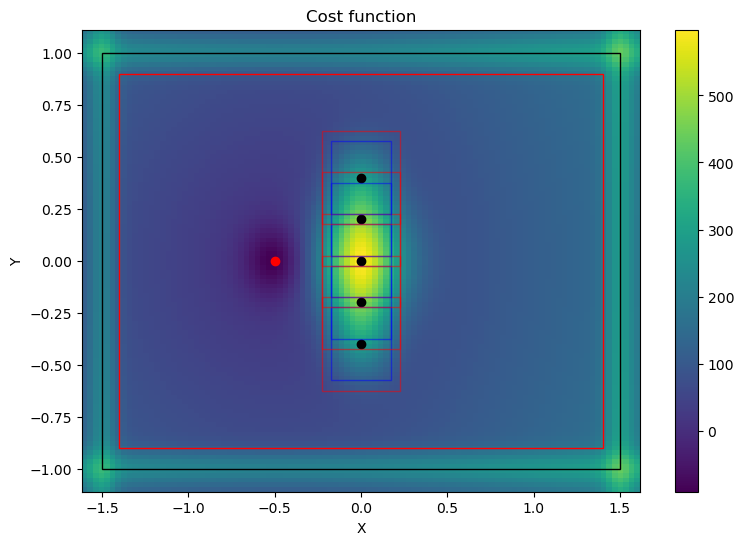

/tmp/ipykernel_21271/877429656.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points)


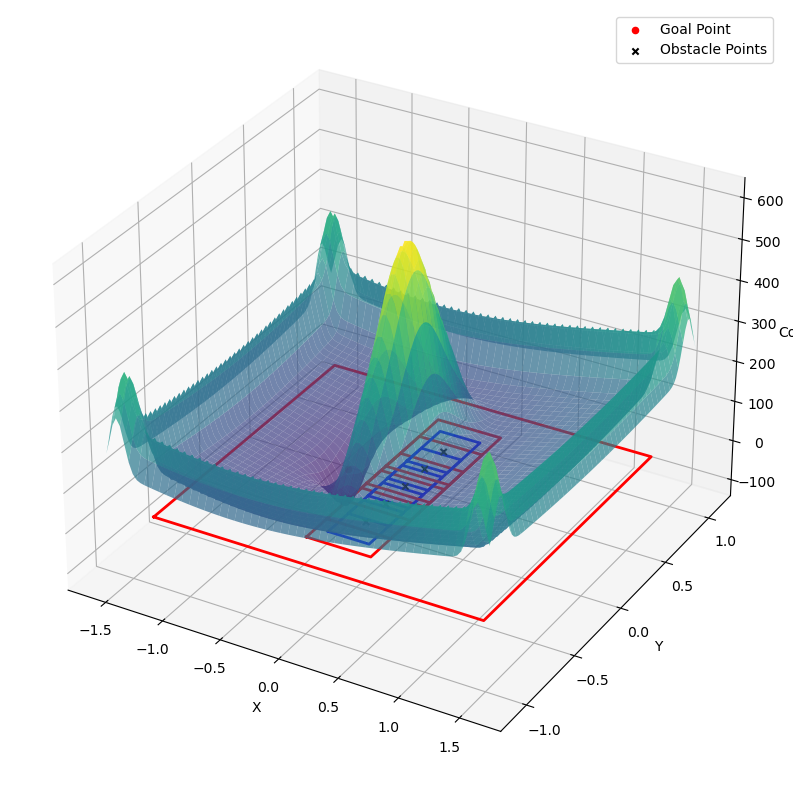

In [18]:
goal_points = np.array(np.mat('-0.5; 0; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;-0.4 -0.2 0 0.2 0.4;0 0 0 0 0'))
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.45;0.95; 3.14')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('0.25;0.25; 0')),np.array(np.mat('1.4;0; 3.14')),np.array(np.mat('1.45;-0.5; 3.14')),np.array(np.mat('1;-0.95; 0')), np.array(np.mat('0.25; 0; 0')),
                      np.array(np.mat('-0.225;-0.95; 3.14')),np.array(np.mat('0.8; 0.85; -1.57')), np.array(np.mat('-1.45;0.95; 0')),np.array(np.mat('-1.45;0.25; 0')),np.array(np.mat('-1.4; -0.9; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

/tmp/ipykernel_21271/3530910157.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points)


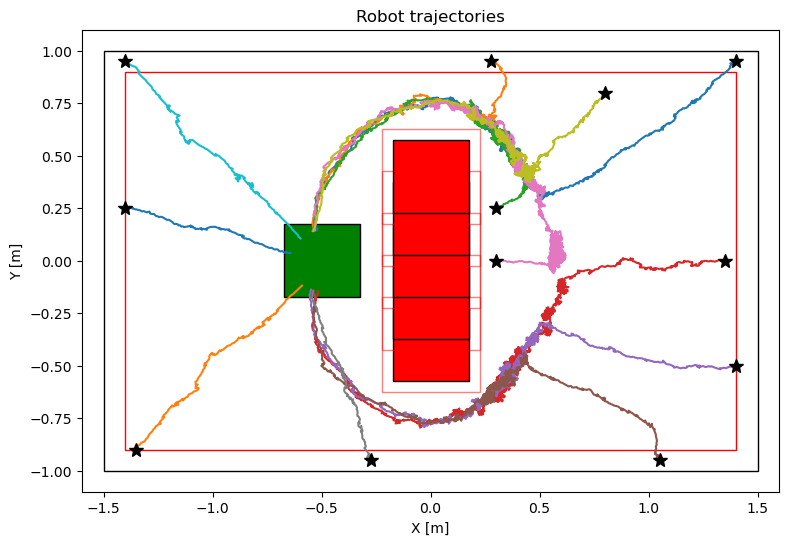

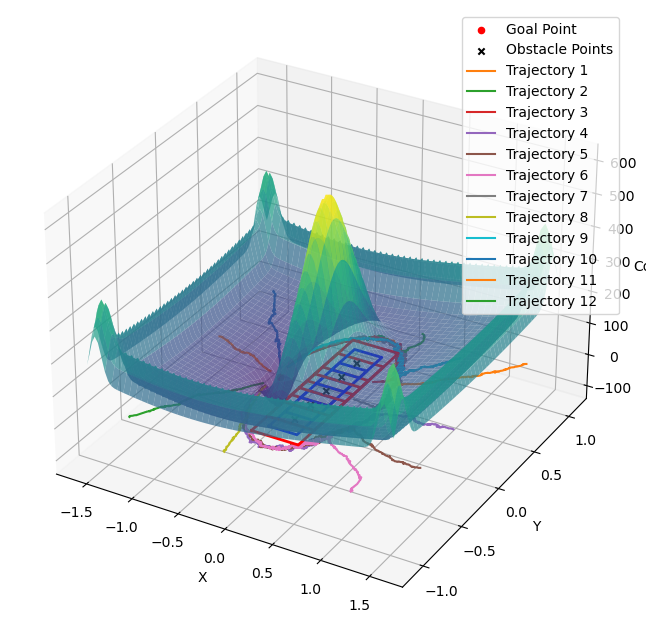

In [20]:
XX=X_Si
UU=D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

In [21]:
#%%capture
w = IOC_resolution(N_feature)

/tmp/ipykernel_21271/2790776063.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
/home/poggi28/miniconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/poggi28/miniconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``p

In [22]:
weights = w.value
print('weights:',weights)

weights: [[-1.01925708e+01 -5.84237941e-01 -7.77399008e-01 -2.83481968e-01
  -7.27445943e-01 -9.80326830e-01 -2.24706271e+00 -9.55101939e-01
   9.03136597e-02  1.90557255e+00  1.55178955e-02 -3.23441914e+00
  -3.45921500e-03 -1.33226921e+00 -6.15341268e+01 -1.89647987e+00
  -2.10335708e-02  6.89484353e-02  3.42385247e-02  2.51793778e-01
   2.31327988e-01  5.26620474e-01  3.30341972e-02 -3.35185154e-02
   8.72614449e-02  1.24947196e+00 -8.27053005e-02]]


In [24]:
Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

/tmp/ipykernel_21271/2891842791.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)


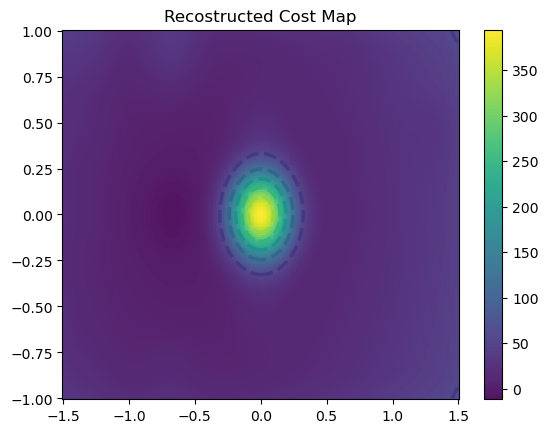

/tmp/ipykernel_21271/1192411458.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = state_cost_estimated(np.array([X[i, j], Y[i, j]]), goal_points, obs_points, weights)


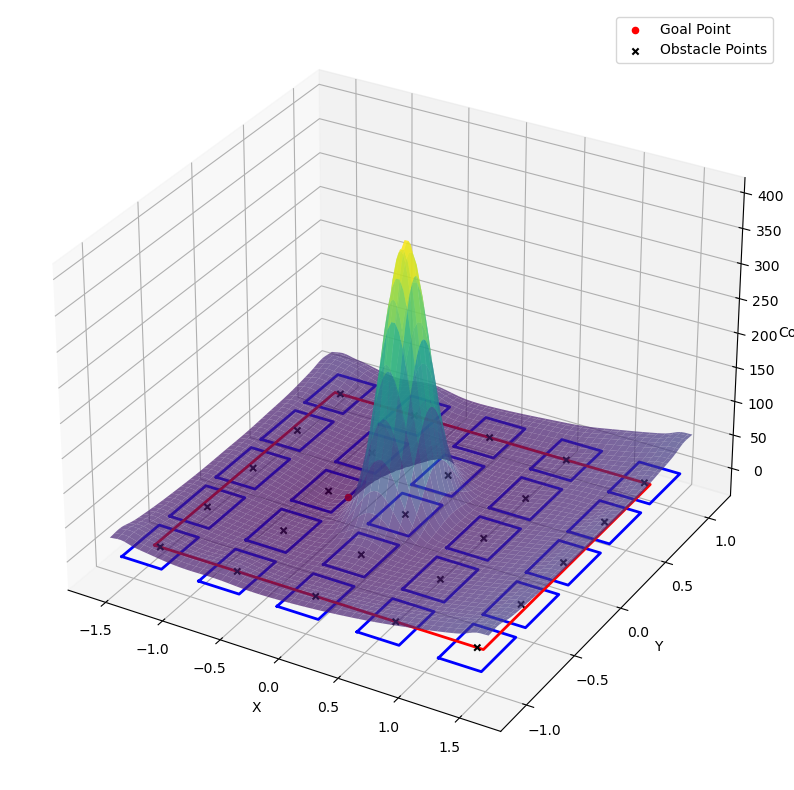

In [35]:
plot_heatmap_recostructed(Cost_Map)
plot_3d_heatmap_recostructed(goal_points, obs_points_f)

In [29]:
%matplotlib inline

In [27]:
goal_points = np.array(np.mat('-0.5; 0; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;-0.4 -0.2 0 0.2 0.4;0 0 0 0 0'))
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]

In [28]:
X_Si,D_Xi=genericSimulationIOC(initial_conditions,goal_points,obs_points, obs_points_f)


/tmp/ipykernel_21271/1317204862.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability


##### DEBUG OUTPUT #####
Your simulation will take approximately 22 real seconds when deployed on the Robotarium. 

	 Simulation had 14396 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 478 real seconds when deployed on the Robotarium. 

	 Simulation had 26804 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 707 real seconds when deployed on the Robotarium. 

	 Simulation had 45191 iteration(s) where the actuator limits were exceeded.


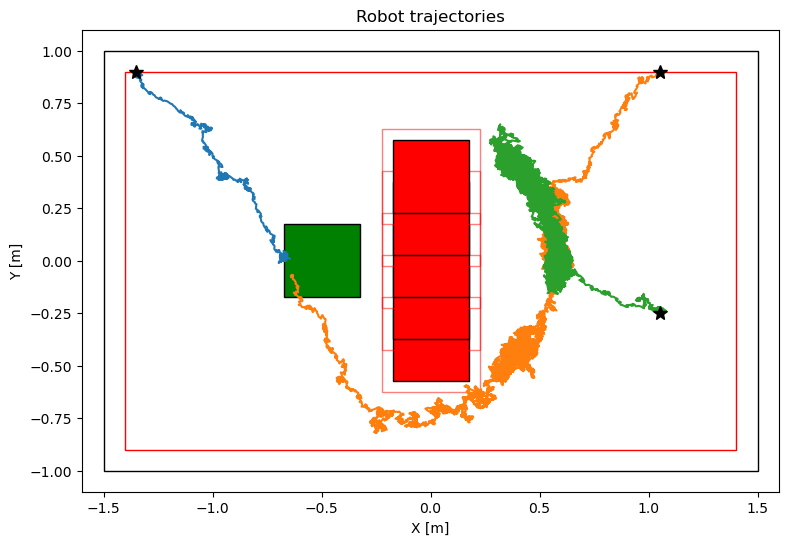

In [30]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

Anche per questo caso, per risolvere il problema dell'IOC c'è bisogno di un numero di simulazioni tali da ricoprire le varie casistiche del robot. All'aumentare delle simulazioni, ovviamente, aumenterà anche l'accuratezza del costo ricostruito a discapito, però, della complessità computazionale. Per tale motivo si è deciso di limitare il numero di simulazioni per mantenere il costo computazionale ragionevole. In questo particolare caso, inoltre, dato il numero limitato di simulazioni, a volte il robot riesce a raggiungere l'obbiettivo seppur con molta rumorosità, mentre altre volte rimane bloccato. Per risolvere questo problema si potrebbe pensare di aumentare il numero di simulazioni, ma ribadiamo che ciò comporterebbe un aumento significativo del costo computazionale e delle tempistiche.

### Caso di robot che parte incastrato

/tmp/ipykernel_21271/883835050.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = state_cost(np.array([X[i,j],Y[i,j]]),goal_points,obs_points)


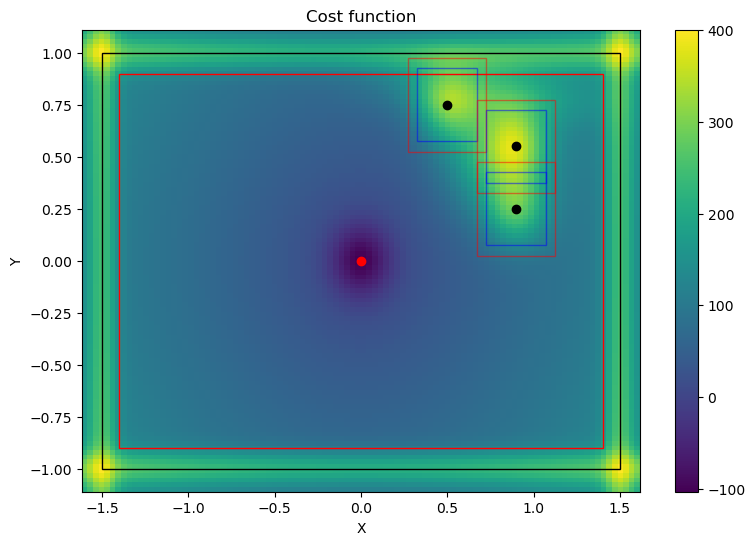

/tmp/ipykernel_21271/1512275492.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points)


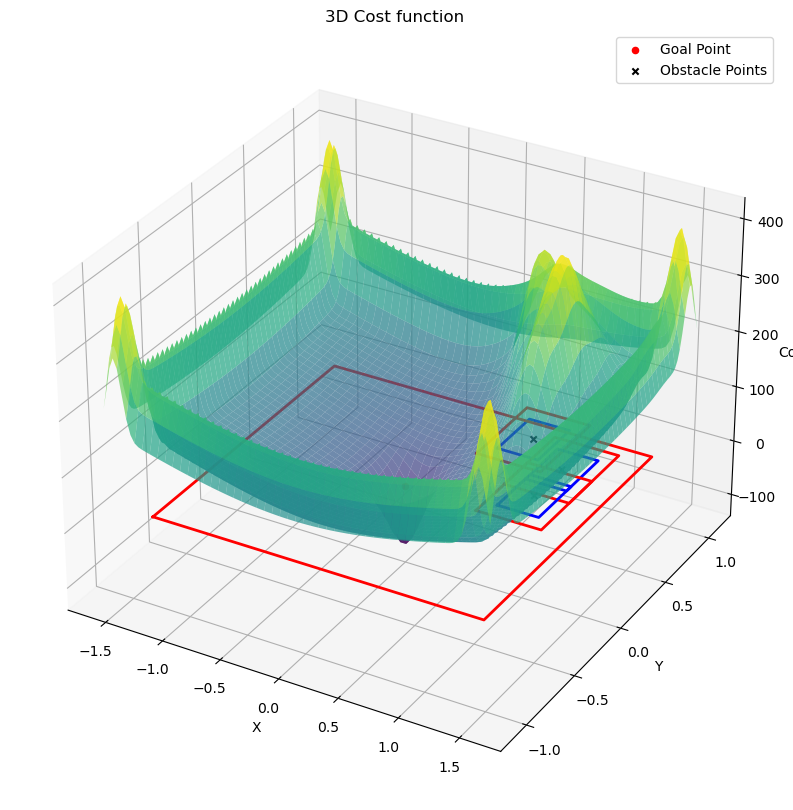

In [38]:
goal_points = np.array(np.mat('0; 0; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.25; 0 0 0' ))
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

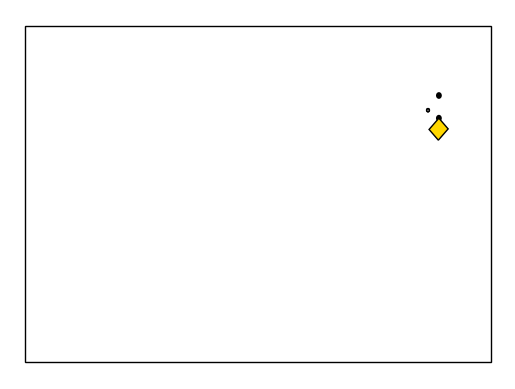

/tmp/ipykernel_21271/1317204862.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability


##### DEBUG OUTPUT #####
Your simulation will take approximately 17 real seconds when deployed on the Robotarium. 

	 Simulation had 55953 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

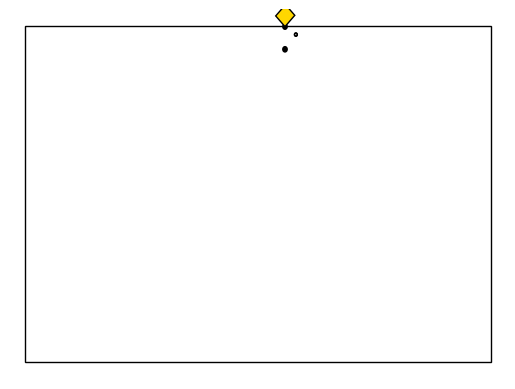

##### DEBUG OUTPUT #####
Your simulation will take approximately 6 real seconds when deployed on the Robotarium. 

	 Simulation had 56103 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

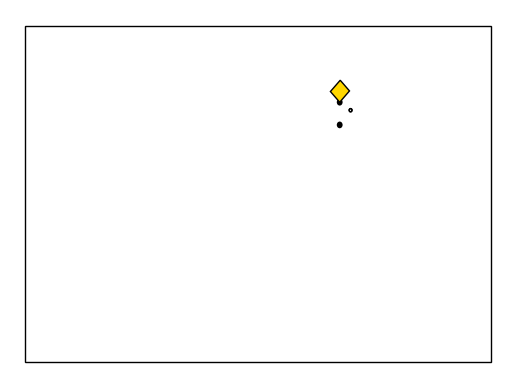

##### DEBUG OUTPUT #####
Your simulation will take approximately 4 real seconds when deployed on the Robotarium. 

	 Simulation had 56210 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

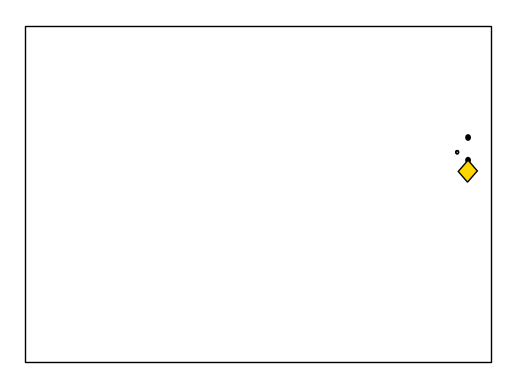

##### DEBUG OUTPUT #####
Your simulation will take approximately 14 real seconds when deployed on the Robotarium. 

	 Simulation had 56569 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

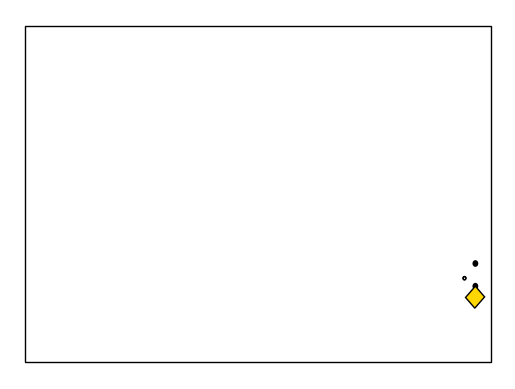

##### DEBUG OUTPUT #####
Your simulation will take approximately 11 real seconds when deployed on the Robotarium. 

	 Simulation had 56858 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

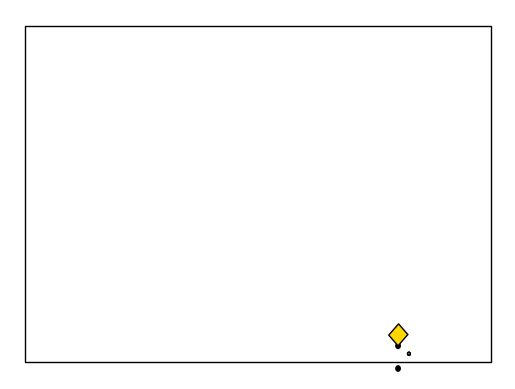

##### DEBUG OUTPUT #####
Your simulation will take approximately 10 real seconds when deployed on the Robotarium. 

	 Simulation had 57132 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

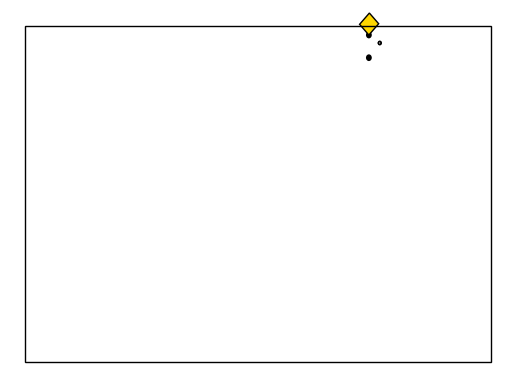

##### DEBUG OUTPUT #####
Your simulation will take approximately 25 real seconds when deployed on the Robotarium. 

	 Simulation had 57795 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

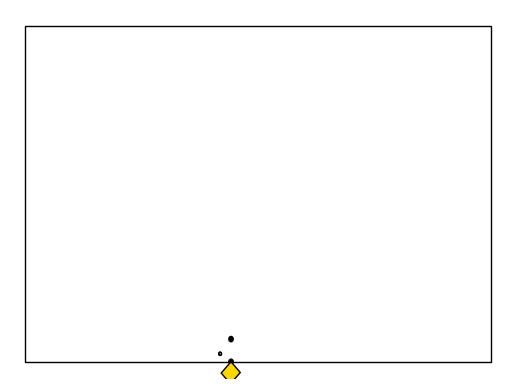

##### DEBUG OUTPUT #####
Your simulation will take approximately 7 real seconds when deployed on the Robotarium. 

	 Simulation had 57969 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

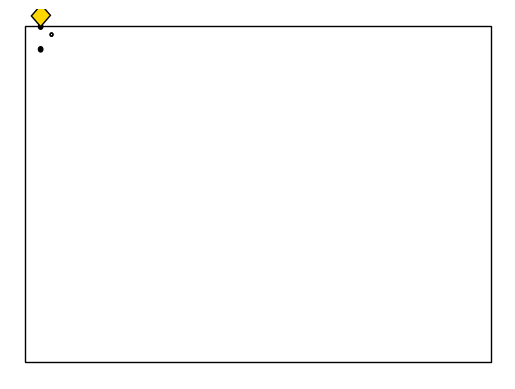

##### DEBUG OUTPUT #####
Your simulation will take approximately 12 real seconds when deployed on the Robotarium. 

	 Simulation had 58275 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

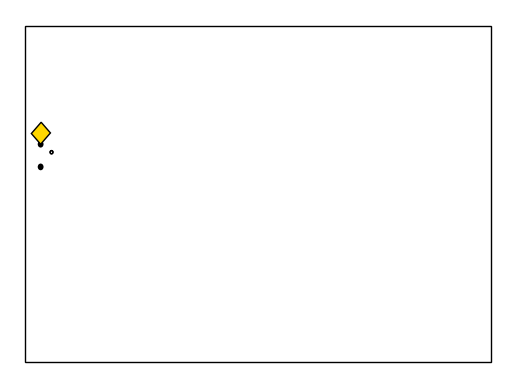

##### DEBUG OUTPUT #####
Your simulation will take approximately 10 real seconds when deployed on the Robotarium. 

	 Simulation had 58527 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

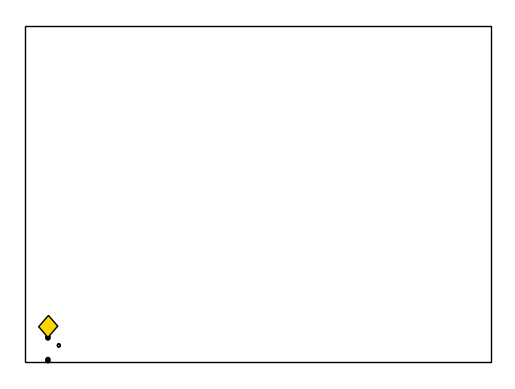

##### DEBUG OUTPUT #####
Your simulation will take approximately 11 real seconds when deployed on the Robotarium. 

	 Simulation had 58825 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

In [50]:
initial_conditions = [np.array(np.mat('1.2; 0.5; 3.14')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('0.6; 0.5; 0')),np.array(np.mat('1.4; 0.25; 3.14')),np.array(np.mat('1.45;-0.5; 3.14')),np.array(np.mat('1;-0.95; 0')), np.array(np.mat('0.8; 0.9; 0')),
                      np.array(np.mat('-0.225;-0.95; 3.14')), np.array(np.mat('-1.45;0.95; 0')),np.array(np.mat('-1.45;0.25; 0')),np.array(np.mat('-1.4; -0.9; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)


/tmp/ipykernel_21271/2814565294.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points)


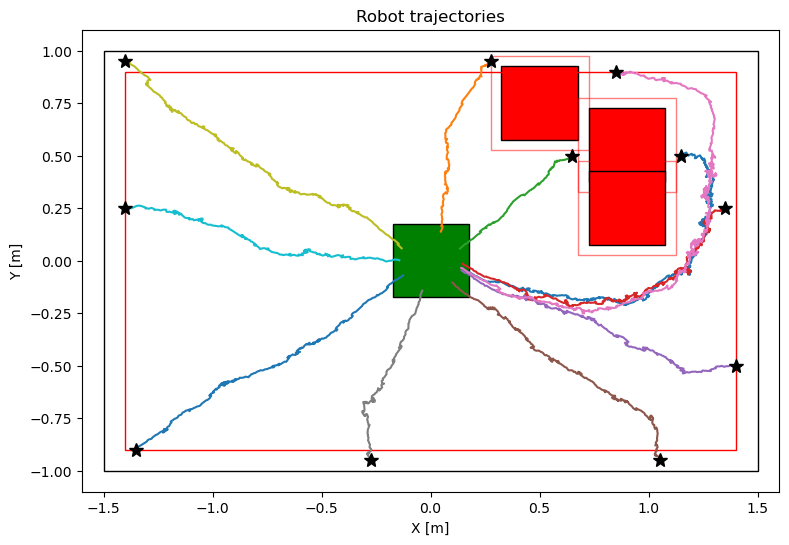

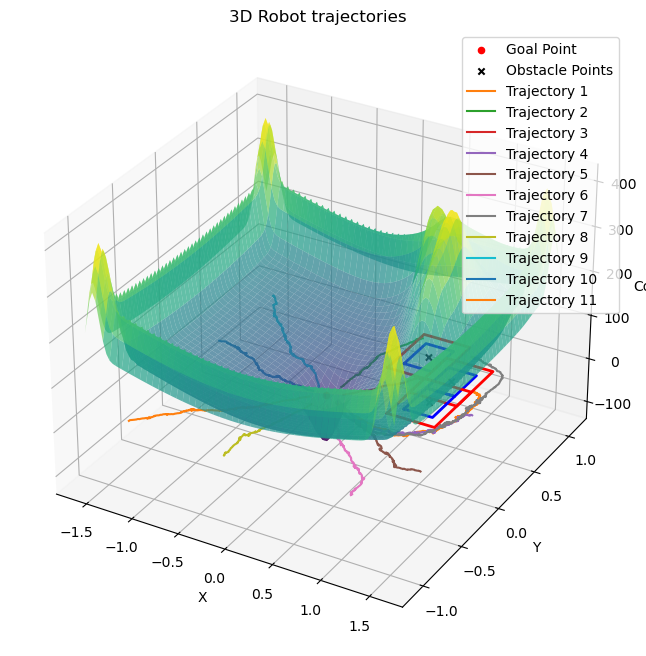

In [51]:
XX=X_Si
UU=D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

In [52]:
w = IOC_resolution(N_feature)
weights = w.value

print('weights:',weights)

/tmp/ipykernel_21271/2790776063.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
/home/poggi28/miniconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
/home/poggi28/miniconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``p

weights: [[-18.06683542  -0.14039658   0.55516122   1.64892541   0.5988231
    0.50441267   0.50870881   1.48949248  -0.30792984   0.21570183
   -0.37307697  -2.95624853   0.14565446   0.35677031   2.56991279
    0.30839666   0.33796072  -0.28652461  -0.28483592  -0.32507334
   -1.89010718  -3.81601282   3.58296572   0.46366443   1.57454454
    2.04571123   2.56864833]]


In [53]:
Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

/tmp/ipykernel_21271/2891842791.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)


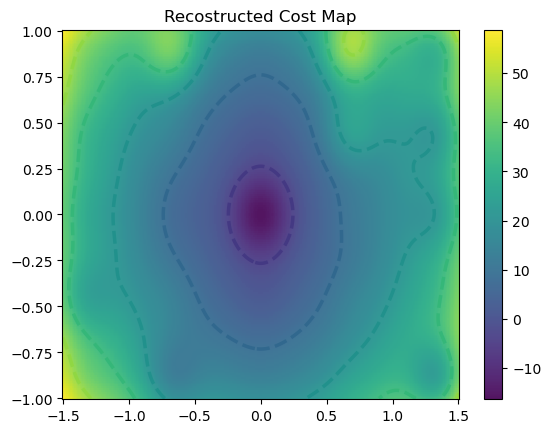

/tmp/ipykernel_21271/3279878733.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = state_cost_estimated(np.array([X[i, j], Y[i, j]]), goal_points, obs_points, weights)


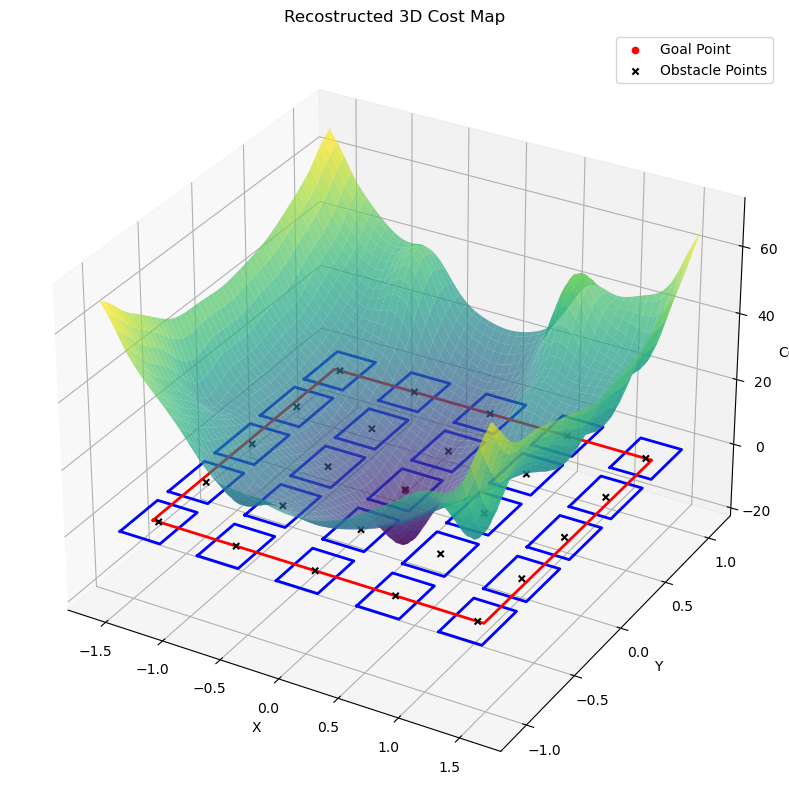

In [54]:
plot_heatmap_recostructed(Cost_Map)
plot_3d_heatmap_recostructed(goal_points, obs_points_f)

In [48]:
%matplotlib qt

In [47]:
goal_points = np.array(np.mat('0; 0; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.25; 0 0 0' ))
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1.4;0.9; 3.14')),np.array(np.mat('1;0.9; 0'))]
X_Si,D_Xi=genericSimulationIOC(initial_conditions,goal_points,obs_points, obs_points_f)


/tmp/ipykernel_21271/1317204862.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability


##### DEBUG OUTPUT #####
Your simulation will take approximately 27 real seconds when deployed on the Robotarium. 

	 Simulation had 51511 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 81 real seconds when deployed on the Robotarium. 

	 Simulation had 53618 iteration(s) where the actuator limits were exceeded.
##### DEBUG OUTPUT #####
Your simulation will take approximately 71 real seconds when deployed on the Robotarium. 

	 Simulation had 55501 iteration(s) where the actuator limits were exceeded.


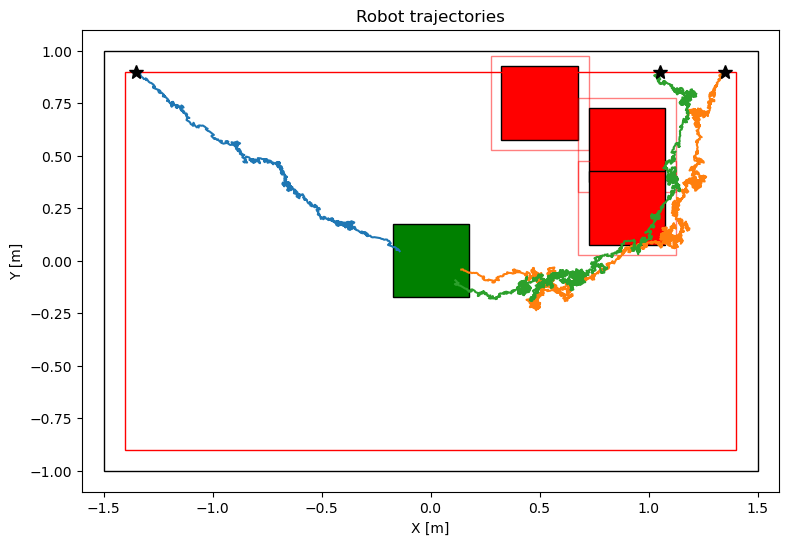

In [49]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

Note + ecc

### Codice di esempio per l'esperimento

Per altri esperimenti, si è deciso di lasciare una sezione in cui bisogna semplicemente modificare obiettivo, ostacoli e condizioni iniziali per effettuare altri tipi di simulazioni

In [ ]:
goal_points = np.array(np.mat('-0.5; 0; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;-0.4 -0.2 0 0.2 0.4;0 0 0 0 0'))
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.45;0.95; 0')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('0.225;0.25; 3.14')),np.array(np.mat('1.4;0.25; 0')),np.array(np.mat('1.45;-0.75; 3.14')),np.array(np.mat('1;-0.95; 0')),
                      np.array(np.mat('0.225;-0.95; 0')),np.array(np.mat('-0.225;-0.95; 3.14')), np.array(np.mat('-0.225;0.95; 0')),np.array(np.mat('-0.225;0.45; 0')), np.array(np.mat('-1.45;0.95; 0')),np.array(np.mat('-1.45;0.25; 0'))]


In [ ]:
XX=X_Si
UU=D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

In [ ]:
w = IOC_resolution(N_feature)
weights = w.value

print('weights:',weights)

In [ ]:


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

In [ ]:
plot_heatmap_recostructed(Cost_Map)
plot_3d_heatmap_recostructed(goal_points, obs_points_f)

In [ ]:
X_Si,D_Xi=genericSimulationIOC(initial_conditions,goal_points,obs_points, obs_points_f)


In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

Note + ecc

# Altra monnezza

### Resto del codice

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_heatmap_recostructed(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost_estimated(np.array([X[i, j], Y[i, j]]), goal_points, obs_points, weights)
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.97)  # Update alpha value here 
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  # Update alpha value here 

    original_list=[] 
    for i in range(len(X_plot)): 
        new_inner_list=[] 
        for j in range(len(X_plot[i])): 
            new_array_3d=np.append(X_plot[i][j],state_cost(X_plot[i][j],goal_points,obs_points)) 
            new_inner_list.append(new_array_3d) 
            
        original_list.append(new_inner_list) 
    
    for i in range(len(X_plot)): 
        original_array = np.array(original_list[i]) 
        plt.plot(original_array[:, 0], original_array[:, 1],  0,  label=f'Trajectory {i+1}')
    
    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        square_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        square_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
       # Add larger red square centered at obstacle points
        square_x_large = [obs_points[0, i] - 0.275, obs_points[0, i] - 0.275, obs_points[0, i] + 0.275, obs_points[0, i] + 0.275, obs_points[0, i] - 0.275]
        square_y_large = [obs_points[1, i] - 0.275, obs_points[1, i] + 0.275, obs_points[1, i] + 0.275, obs_points[1, i] - 0.275, obs_points[1, i] - 0.275]
        ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    ax.legend() 
    plt.show()

In [ ]:
plot_3d_heatmap_recostructed(goal_points,obs_points_f)
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points) 

In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost

'''
La funzione ha la sintassi e il significato analogo a quella definita per il problema di FOC, con la sola differenza che il costo dello stato viene calcolato con i pesi ottenuti dall'ottimizzazione,
e quindi il costo è quello stimato dal problema IOC.
'''
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                # Queste tre linee di codice calcolano il prossimo stato, a partire da una delle 9 azioni scandite
                # dai cicli for, e creano una multivariata normale centrata nel prossimo stato con covarianza data

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                # Queste due linee di codice campionano 20 campioni dalla distribuzione calcolata precedentemente

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                # Calcoliamo il costo medio dei campioni secondo la funzione state_cost, si tratta di calcolare
                # l'expected value della formula per la policy

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                # print("entropy: " + str(f.entropy()))
                # print("next state: " + str(next_state))
                # print("cost: " + str(cost))

                log_DKL = np.exp(-cost+f.entropy())

                # la log_DKL è uguale, secondo formulazione, a np.exp(-DKL-costoatteso), il costo atteso lo abbiamo calcolato
                # al punto precedente, mentre la DKL(f||g), dato che g è uniforme, diventa semplicemente l'entropia con un termine 
                # log(q) derivante da calcoli algebrici
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) # Da traccia
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) # Da traccia
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]


In [ ]:
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supponendo che 'obs_points_f' e 'weights' siano definiti

# Plot dei punti caratteristici sulla griglia
plt.figure(figsize=(8, 6))
newWeights=-weights[0][5:]# Normalizza i pesi nell'intervallo 100-1000
weights_normalized = (newWeights - newWeights.min()) / (newWeights.max() - newWeights.min())
weights_mapped = 100 + (weights_normalized * 900)  # Scala il valore tra 100 e 1000

# Plot dei punti caratteristici con dimensioni basate sui pesi
plt.scatter(obs_points_f[0], obs_points_f[1], s=weights_mapped, c='red', marker='o')

# Plot del testo con i pesi corrispondenti
for i in range(len(newWeights)):
    plt.text(obs_points_f[0, i], obs_points_f[1, i]-0.15, f'{-newWeights[i]:.2f}', fontsize=8, color='black')

plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.title('Punti caratteristici sulla griglia del Robotarium con pesi')
plt.legend()
plt.grid(True)

plt.xlim(-1.5, 1.5)
plt.ylim(-1, 1)

plt.show()

# Cambio delle feature (Robot che parte diedro un muro)

Consideriamo il caso in cui il robot parta in un angolo tra degli ostacoli ed il goal point sia dietro questi ostacoli.

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
'''
Data la funzione di costo:
'''
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0
    cost2 = 0
    for i in range(len(centroidi)):
            dist= (goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2 # da cambiare se sono più goal point #TODO
            dist=dist if dist < 0.175 else 1 #(% 1 è per evitare di farla divergere, cioè mantenerla in 1 però è da verificare)
            cost2 += 20*my_logpdf(state[:2],centroidi[i][:2],np.diag(np.array([0.04, 0.04], dtype=np.float32)))*(centroidi[i][2]-1)*dist
            # Se il centroide è trppo vicino al goal point, allora la gaussiana è molto piccola, evitando di rischiare di portare il robot a non voler andare verso il goal point

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 
    
    sigma=0.06
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cost2
   

    return(cost)

In [ ]:
import numpy as np
goal_points = np.array(np.mat('0; 0; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.20; 0 0 0' ))

# initial_conditions = [np.array(np.mat('0.7; 0.85; 0')), np.array(np.mat('1.4; 0.9; 3.14')), np.array(np.mat('0.6; 0.45; 0'))]
initial_conditions = [np.array(np.mat('0.7; 0.85; 0')), np.array(np.mat('1.4; 0.9; 3.14')), np.array(np.mat('0.6; 0.45; 0')), np.array(np.mat('1.45;0.95; 0')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('-1.0; -0.75; 3.14')),np.array(np.mat('1.45; 0.25; 3.14')),np.array(np.mat('1.45;-0.75; 3.14')),np.array(np.mat('1;-0.95; 0')),
                      np.array(np.mat('0.225;-0.95; 0')),np.array(np.mat('-0.225;-0.95; 3.14')), np.array(np.mat('-0.225;0.95; 0')),np.array(np.mat('-1.4; -0.95; 1.57')), np.array(np.mat('-1.45;0.95; 0')),np.array(np.mat('-1.45;0.25; 0'))]



# for _ in range(20):
#     x = np.random.uniform(-1.45, 1.45)
#     y = np.random.uniform(-0.95, 0.95)
#     initial_conditions.append(np.array([[x], [y], [0]]))


plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
# Se vuoi runnare di nuovo il FOC devi rieseguire il codice di definizione della control_step sopra.
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

### Feature del prof

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0')) # da traccia
plot_heatmap(goal_points,obs_points_f)

In [ ]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
    return features


### Feature nostre

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('-1.35 -1.35 -1.35 -1.35 -1.35 -0.675 -0.675 -0.675 -0.675 -0.675 0 0 0 0 0 0.675 0.675 0.675 0.675 0.675 1.35 1.35 1.35 1.35 1.35;-0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))
plot_heatmap(goal_points,obs_points_f)


In [ ]:
N_feature = np.size(obs_points_f,axis=1)+1+1 # 1 per la distanza dal goal point, 1 per la gaussiana sul goal point, 4 per i muri

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    sigma=0.06
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) # per il goal point
    features[1] = (1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) + np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) + np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2))
    
    # tollerance=1e-2  
    # features[2] = ((1/((next_state[0]-1.5)**2  + tollerance))) + 1/((1.5-goal_points[0])**2+tollerance) # per il muro a destra
    # features[3] = ((1/((next_state[0]-(-1.5))**2  + tollerance))) + 1/((-1.5-goal_points[0])**2+tollerance)  # per il muro a sinistra
    # features[4] = ((1/((next_state[1]-1.0)**2  + tollerance))) + 1/((1.0-goal_points[1])**2+tollerance) # per il muro sopra
    # features[5] = ((1/((next_state[1]-(-1.0))**2  + tollerance))) + 1/((-1.0-goal_points[1])**2+tollerance)  # per il muro sotto

    # sigma=0.06
    # features[2] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) # per il muro a destra
    # features[3] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)  # per il muro a sinistra
    # features[4] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) # per il muro sopra
    # features[5] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2)  # per il muro sotto
    
    return features


### Codice per l'ioc

In [ ]:
#%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []

f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean

            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            '''
            Questo riga rappresenta il termine (5) descritto nel markdown, in particolare rappresenta l'esponenziale dell'entropia cambiata di segno.
            '''

            pf[j,k] = log_DKL
    PF[:,:,i] = pf

    features = np.reshape(features,(N_feature,control_space_size**2)) # N features x 9

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    tempPF = np.reshape(PF,(control_space_size**2,M)) # N features x 9

    l =-(w @ feature_sampled[:,i])+cp.log_sum_exp(cp.reshape(w@features[:,:],(9,))+cp.log(tempPF[:,i]))
    
    '''
    Ogni termine l, rappresenta il singolo termine della sommatoria (4) descritta nel markdown, in particolare, dato che il codice pre-esistente già calcolava il termine (5) e il termine (6), lo scopo di questa parte di codice
    è quello di configurare le dimensionalità dei vari termini, effettuando un reshape della PF calcolata, portandola da una dimensionalità (N feature x 3 x 3), a una dimensionalità (N x 9) per essere gestita nella somma con il prodotto dei pesi con le features.
    Inoltre, dato che stiamo risolvendo un problema di LSE tramite cvx, dobbiamo fornirgli in input il valore atteso del prodotto tra pesi e feature, e il valore atteso della f cambiata di segno, rappresentato dall'entropia,
    ma dato che ci viene già fornito dal codice l'esponenziale dell'entropia, cambiata di segno, dobbiamo sommare il logaritmo di questa quantità in modo da riportarci nella forma originale del problema (4).
    '''
    
    # (ii) sum all the elements to define the cost function
    L.append(l)

    '''
    Con queste linee di codice creiamo l'intera sommatoria su M esperimenti.
    '''

    # (iii) solve the problem 
objective = cp.Minimize(cp.sum(L))

prob = cp.Problem(objective)

result = prob.solve(verbose = False)

'''
Infine risolviamo il problema, facendo uso di cvx, minimizzando la sommatoria dei termini l, ottenendo i pesi w ottimi delle feature scelte.
'''

print("status:", prob.status)
print("optimal value", prob.value)

In [ ]:
weights = w.value

print('weights:',weights)

### Costo ricostruito professore

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

# goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Costro ricostruito nostro

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    # tollerance=1e-2
    # walls_sum = -(weights[:,2]*1/((state[0]-1.5)**2 + tollerance) + weights[:,3]*1/((state[0]-(-1.5))**2 + tollerance) + weights[:,4]*1/((state[1]-1.0)**2 + tollerance) + weights[:,5]*1/((state[1]+(-1.0))**2 + tollerance))

    sigma=0.06
    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum -weights[:,1]*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Resto del codice

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

'''
In questo pezzo di codice viene visualizzato il costo dello stato calcolato con i pesi ottenuti dall'ottimizzazione, ovvero il costo stimato. In particolare, è rappresentato come una heatmap analogamente a quanto accaduto
per il costo definito nel problema di FOC. Inoltre, sono state anche disegnate delle linee tratteggiate che rappresentano i livelli di costo.
'''

# Transpose the data array to rotate the heatmap
#data_rotated = np.transpose(Coat_Map) Costo effettivo
data_rotated = np.transpose(Cost_Map)

plt.figure()
# Plotting the pcolormesh for the data
plt.pcolormesh(X_axis, Y_axis, data_rotated, cmap='viridis', alpha=0.92)
plt.colorbar()

# Define contour levels to create 6 regions
contour_levels = np.linspace(data_rotated.min(), data_rotated.max(), 7)  # 7 levels for 6 regions

# Get colors based on the viridis colormap for the given contour levels
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(contour_levels)))

for i, level in enumerate(contour_levels):
    plt.contour(X_axis, Y_axis, data_rotated, levels=[level], colors=[viridis_colors[i]], linewidths=2.5, linestyles='dashed')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_heatmap_recostructed(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost_estimated(np.array([X[i, j], Y[i, j]]), goal_points, obs_points, weights)
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.97)  # Update alpha value here 
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  # Update alpha value here 

    original_list=[] 
    for i in range(len(X_plot)): 
        new_inner_list=[] 
        for j in range(len(X_plot[i])): 
            new_array_3d=np.append(X_plot[i][j],state_cost(X_plot[i][j],goal_points,obs_points)) 
            new_inner_list.append(new_array_3d) 
            
        original_list.append(new_inner_list) 
    
    for i in range(len(X_plot)): 
        original_array = np.array(original_list[i]) 
        plt.plot(original_array[:, 0], original_array[:, 1],  0,  label=f'Trajectory {i+1}')
    
    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        square_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        square_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
       # Add larger red square centered at obstacle points
        square_x_large = [obs_points[0, i] - 0.275, obs_points[0, i] - 0.275, obs_points[0, i] + 0.275, obs_points[0, i] + 0.275, obs_points[0, i] - 0.275]
        square_y_large = [obs_points[1, i] - 0.275, obs_points[1, i] + 0.275, obs_points[1, i] + 0.275, obs_points[1, i] - 0.275, obs_points[1, i] - 0.275]
        ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    ax.legend() 
    plt.show()

In [ ]:
plot_3d_heatmap_recostructed(goal_points,obs_points_f)

In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost

'''
La funzione ha la sintassi e il significato analogo a quella definita per il problema di FOC, con la sola differenza che il costo dello stato viene calcolato con i pesi ottenuti dall'ottimizzazione,
e quindi il costo è quello stimato dal problema IOC.
'''
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                # Queste tre linee di codice calcolano il prossimo stato, a partire da una delle 9 azioni scandite
                # dai cicli for, e creano una multivariata normale centrata nel prossimo stato con covarianza data

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                # Queste due linee di codice campionano 20 campioni dalla distribuzione calcolata precedentemente

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                # Calcoliamo il costo medio dei campioni secondo la funzione state_cost, si tratta di calcolare
                # l'expected value della formula per la policy

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                # print("entropy: " + str(f.entropy()))
                # print("next state: " + str(next_state))
                # print("cost: " + str(cost))

                log_DKL = np.exp(-cost+f.entropy())

                # la log_DKL è uguale, secondo formulazione, a np.exp(-DKL-costoatteso), il costo atteso lo abbiamo calcolato
                # al punto precedente, mentre la DKL(f||g), dato che g è uniforme, diventa semplicemente l'entropia con un termine 
                # log(q) derivante da calcoli algebrici
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [ ]:
goal_points = np.array(np.mat('0; 0; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.20; 0 0 0' ))

initial_conditions = [np.array(np.mat('0.7; 0.85; 0')), np.array(np.mat('1.4; 0.9; 3.14')), np.array(np.mat('0.6; 0.45; 0'))]


In [ ]:
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supponendo che 'obs_points_f' e 'weights' siano definiti

# Plot dei punti caratteristici sulla griglia
plt.figure(figsize=(8, 6))
newWeights=-weights[0][5:]# Normalizza i pesi nell'intervallo 100-1000
weights_normalized = (newWeights - newWeights.min()) / (newWeights.max() - newWeights.min())
weights_mapped = 100 + (weights_normalized * 900)  # Scala il valore tra 100 e 1000

# Plot dei punti caratteristici con dimensioni basate sui pesi
plt.scatter(obs_points_f[0], obs_points_f[1], s=weights_mapped, c='red', marker='o')

# Plot del testo con i pesi corrispondenti
for i in range(len(newWeights)):
    plt.text(obs_points_f[0, i], obs_points_f[1, i]-0.15, f'{-newWeights[i]:.2f}', fontsize=8, color='black')

plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.title('Punti caratteristici sulla griglia del Robotarium con pesi')
plt.legend()
plt.grid(True)

plt.xlim(-1.5, 1.5)
plt.ylim(-1, 1)

plt.show()

È una situazione sicuramente critica per il robot. Si fa notare che c'è bisogno di abbastanza esperimenti per ricostruire bene il costo.

# Cambio delle feature (Goal point dietro gli ostacoli)

Consideriamo il caso in cui il robot parta in un angolo tra degli ostacoli ed il goal point sia dietro questi ostacoli.

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
####### MODIFCATA ########
'''
Data la funzione di costo:
'''
def state_cost(state,goal_points,obs_points): 
    centroidi=clustering(obs_points) 
 
    v = np.array([0.015, 0.015], dtype=np.float32) 
    covar = np.diag(v) 
    gauss_sum = 0 
    cost2 = 0 
    for i in range(len(centroidi)): 
            dist= np.sqrt((goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2) # da cambiare se sono più goal point #TODO 
            dist=dist if dist < 0.175 else 1 #(% 1 è per evitare di farla divergere, cioè mantenerla in 1 però è da verificare) 
            cost2 += 20*my_logpdf(state[:2],centroidi[i][:2],np.diag(np.array([0.04, 0.04], dtype=np.float32)))*(centroidi[i][2]-1)*dist 
            # Se il centroide è troppo vicino al goal point, allora la gaussiana è molto piccola, evitando di rischiare di portare il robot a non voler andare verso il goal point 
 
    for i in range(np.size(obs_points,axis=1)): 
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar)  
 
    muri=[np.array([1.5,0.0,0.0]),np.array([-1.5,0.0,0.0]),np.array([0.0,1.0,0.0]),np.array([0.0,-1.0,0.0])] 
    muri_gauss_sum=0 
    
    covar_muri_oriz=np.diag(np.array([0.01, 0.1], dtype=np.float32))
    covar_muri_vert=np.diag(np.array([0.1, 0.01], dtype=np.float32))
    
    for i in range (4): 
        for j in range (np.size(obs_points,axis=1)): 
            if(muri[i][0]!=0): 
                 if(np.abs(muri[i][0]-obs_points[0,j])<0.495): 
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([(muri[i][0]+obs_points[0,j])/2,obs_points[1,j]]),covar_muri_oriz) 
            else: 
                if(np.abs(muri[i][1]-obs_points[1,j])<0.495): 
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([obs_points[0,j],(muri[i][1]+obs_points[1,j])/2]),covar_muri_vert) 
                  
    sigma=0.06 
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 75*np.sqrt(((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2)) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2) 
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2)) + cost2 + muri_gauss_sum
    
    # 30*(abs(state[0] - goal_points[0]) + abs(state[1] - goal_points[1]))
    
    return (cost)

In [ ]:
import numpy as np
# goal_points = np.array(np.mat('-1.4; -0.8; 0')) # Da traccia
goal_points = np.array(np.mat('-0.35; 0.5; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) # Da traccia

# initial_conditions = [np.array(np.mat('1.4;0.95; 3.14')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('0.225;0.25; 3.14')),np.array(np.mat('1.45;0.25; 0')),np.array(np.mat('1.45;-0.75; 3.14')),np.array(np.mat('1;-0.95; 0')),
                    #   np.array(np.mat('0.225;-0.95; 0')),np.array(np.mat('-0.225;-0.95; 3.14')), np.array(np.mat('-0.225;0.95; 0')),np.array(np.mat('-0.225;0.45; 0')), np.array(np.mat('-1.45;0.95; 0')),np.array(np.mat('-1.45;0.25; 0'))]

initial_conditions = [np.array(np.mat('1.4;0.95; 3.14')),np.array(np.mat('0.225;0.95; 0'))]

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
# Se vuoi runnare di nuovo il FOC devi rieseguire il codice di definizione della control_step sopra.
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

### Feature del prof

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0')) # da traccia
plot_heatmap(goal_points,obs_points_f)

In [ ]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
    return features


### Feature nostre

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('-1.35 -1.35 -1.35 -1.35 -1.35 -0.675 -0.675 -0.675 -0.675 -0.675 0 0 0 0 0 0.675 0.675 0.675 0.675 0.675 1.35 1.35 1.35 1.35 1.35;-0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))
plot_heatmap(goal_points,obs_points_f)


In [ ]:
N_feature = np.size(obs_points_f,axis=1)+1+1 # 1 per la distanza dal goal point, 1 per la gaussiana sul goal point, 4 per i muri

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    sigma=0.06
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) # per il goal point
    features[1] = (1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) + np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) + np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2))
    
    # tollerance=1e-2  
    # features[2] = ((1/((next_state[0]-1.5)**2  + tollerance))) + 1/((1.5-goal_points[0])**2+tollerance) # per il muro a destra
    # features[3] = ((1/((next_state[0]-(-1.5))**2  + tollerance))) + 1/((-1.5-goal_points[0])**2+tollerance)  # per il muro a sinistra
    # features[4] = ((1/((next_state[1]-1.0)**2  + tollerance))) + 1/((1.0-goal_points[1])**2+tollerance) # per il muro sopra
    # features[5] = ((1/((next_state[1]-(-1.0))**2  + tollerance))) + 1/((-1.0-goal_points[1])**2+tollerance)  # per il muro sotto

    # sigma=0.06
    # features[2] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) # per il muro a destra
    # features[3] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)  # per il muro a sinistra
    # features[4] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) # per il muro sopra
    # features[5] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2)  # per il muro sotto
    
    return features


### Codice per l'ioc

In [ ]:
#%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []

f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean

            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            '''
            Questo riga rappresenta il termine (5) descritto nel markdown, in particolare rappresenta l'esponenziale dell'entropia cambiata di segno.
            '''

            pf[j,k] = log_DKL
    PF[:,:,i] = pf

    features = np.reshape(features,(N_feature,control_space_size**2)) # N features x 9

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    tempPF = np.reshape(PF,(control_space_size**2,M)) # N features x 9

    l =-(w @ feature_sampled[:,i])+cp.log_sum_exp(cp.reshape(w@features[:,:],(9,))+cp.log(tempPF[:,i]))
    
    '''
    Ogni termine l, rappresenta il singolo termine della sommatoria (4) descritta nel markdown, in particolare, dato che il codice pre-esistente già calcolava il termine (5) e il termine (6), lo scopo di questa parte di codice
    è quello di configurare le dimensionalità dei vari termini, effettuando un reshape della PF calcolata, portandola da una dimensionalità (N feature x 3 x 3), a una dimensionalità (N x 9) per essere gestita nella somma con il prodotto dei pesi con le features.
    Inoltre, dato che stiamo risolvendo un problema di LSE tramite cvx, dobbiamo fornirgli in input il valore atteso del prodotto tra pesi e feature, e il valore atteso della f cambiata di segno, rappresentato dall'entropia,
    ma dato che ci viene già fornito dal codice l'esponenziale dell'entropia, cambiata di segno, dobbiamo sommare il logaritmo di questa quantità in modo da riportarci nella forma originale del problema (4).
    '''
    
    # (ii) sum all the elements to define the cost function
    L.append(l)

    '''
    Con queste linee di codice creiamo l'intera sommatoria su M esperimenti.
    '''

    # (iii) solve the problem 
objective = cp.Minimize(cp.sum(L))

prob = cp.Problem(objective)

result = prob.solve(verbose = False)

'''
Infine risolviamo il problema, facendo uso di cvx, minimizzando la sommatoria dei termini l, ottenendo i pesi w ottimi delle feature scelte.
'''

print("status:", prob.status)
print("optimal value", prob.value)

In [ ]:
weights = w.value

print('weights:',weights)

### Costo ricostruito professore

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

# goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Costro ricostruito nostro

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    # tollerance=1e-2
    # walls_sum = -(weights[:,2]*1/((state[0]-1.5)**2 + tollerance) + weights[:,3]*1/((state[0]-(-1.5))**2 + tollerance) + weights[:,4]*1/((state[1]-1.0)**2 + tollerance) + weights[:,5]*1/((state[1]+(-1.0))**2 + tollerance))

    sigma=0.06
    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum -weights[:,1]*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Resto del codice

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

'''
In questo pezzo di codice viene visualizzato il costo dello stato calcolato con i pesi ottenuti dall'ottimizzazione, ovvero il costo stimato. In particolare, è rappresentato come una heatmap analogamente a quanto accaduto
per il costo definito nel problema di FOC. Inoltre, sono state anche disegnate delle linee tratteggiate che rappresentano i livelli di costo.
'''

# Transpose the data array to rotate the heatmap
#data_rotated = np.transpose(Coat_Map) Costo effettivo
data_rotated = np.transpose(Cost_Map)

plt.figure()
# Plotting the pcolormesh for the data
plt.pcolormesh(X_axis, Y_axis, data_rotated, cmap='viridis', alpha=0.92)
plt.colorbar()

# Define contour levels to create 6 regions
contour_levels = np.linspace(data_rotated.min(), data_rotated.max(), 7)  # 7 levels for 6 regions

# Get colors based on the viridis colormap for the given contour levels
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(contour_levels)))

for i, level in enumerate(contour_levels):
    plt.contour(X_axis, Y_axis, data_rotated, levels=[level], colors=[viridis_colors[i]], linewidths=2.5, linestyles='dashed')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_heatmap_recostructed(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost_estimated(np.array([X[i, j], Y[i, j]]), goal_points, obs_points, weights)
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.97)  # Update alpha value here 
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  # Update alpha value here 

    original_list=[] 
    for i in range(len(X_plot)): 
        new_inner_list=[] 
        for j in range(len(X_plot[i])): 
            new_array_3d=np.append(X_plot[i][j],state_cost(X_plot[i][j],goal_points,obs_points)) 
            new_inner_list.append(new_array_3d) 
            
        original_list.append(new_inner_list) 
    
    for i in range(len(X_plot)): 
        original_array = np.array(original_list[i]) 
        plt.plot(original_array[:, 0], original_array[:, 1],  0,  label=f'Trajectory {i+1}')
    
    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        square_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        square_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
       # Add larger red square centered at obstacle points
        square_x_large = [obs_points[0, i] - 0.275, obs_points[0, i] - 0.275, obs_points[0, i] + 0.275, obs_points[0, i] + 0.275, obs_points[0, i] - 0.275]
        square_y_large = [obs_points[1, i] - 0.275, obs_points[1, i] + 0.275, obs_points[1, i] + 0.275, obs_points[1, i] - 0.275, obs_points[1, i] - 0.275]
        ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    ax.legend() 
    plt.show()

In [ ]:
plot_3d_heatmap_recostructed(goal_points,obs_points_f)

In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost

'''
La funzione ha la sintassi e il significato analogo a quella definita per il problema di FOC, con la sola differenza che il costo dello stato viene calcolato con i pesi ottenuti dall'ottimizzazione,
e quindi il costo è quello stimato dal problema IOC.
'''
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                # Queste tre linee di codice calcolano il prossimo stato, a partire da una delle 9 azioni scandite
                # dai cicli for, e creano una multivariata normale centrata nel prossimo stato con covarianza data

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                # Queste due linee di codice campionano 20 campioni dalla distribuzione calcolata precedentemente

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                # Calcoliamo il costo medio dei campioni secondo la funzione state_cost, si tratta di calcolare
                # l'expected value della formula per la policy

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                # print("entropy: " + str(f.entropy()))
                # print("next state: " + str(next_state))
                # print("cost: " + str(cost))

                log_DKL = np.exp(-cost+f.entropy())

                # la log_DKL è uguale, secondo formulazione, a np.exp(-DKL-costoatteso), il costo atteso lo abbiamo calcolato
                # al punto precedente, mentre la DKL(f||g), dato che g è uniforme, diventa semplicemente l'entropia con un termine 
                # log(q) derivante da calcoli algebrici
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [ ]:
goal_points = np.array(np.mat('0; 0; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.20; 0 0 0' ))

initial_conditions = [np.array(np.mat('0.7; 0.85; 0')), np.array(np.mat('1.4; 0.9; 3.14')), np.array(np.mat('0.6; 0.45; 0'))]


In [ ]:
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supponendo che 'obs_points_f' e 'weights' siano definiti

# Plot dei punti caratteristici sulla griglia
plt.figure(figsize=(8, 6))
newWeights=-weights[0][5:]# Normalizza i pesi nell'intervallo 100-1000
weights_normalized = (newWeights - newWeights.min()) / (newWeights.max() - newWeights.min())
weights_mapped = 100 + (weights_normalized * 900)  # Scala il valore tra 100 e 1000

# Plot dei punti caratteristici con dimensioni basate sui pesi
plt.scatter(obs_points_f[0], obs_points_f[1], s=weights_mapped, c='red', marker='o')

# Plot del testo con i pesi corrispondenti
for i in range(len(newWeights)):
    plt.text(obs_points_f[0, i], obs_points_f[1, i]-0.15, f'{-newWeights[i]:.2f}', fontsize=8, color='black')

plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.title('Punti caratteristici sulla griglia del Robotarium con pesi')
plt.legend()
plt.grid(True)

plt.xlim(-1.5, 1.5)
plt.ylim(-1, 1)

plt.show()

È una situazione sicuramente critica per il robot. Si fa notare che c'è bisogno di abbastanza esperimenti per ricostruire bene il costo.

In [ ]:
'''
#TODO Riprovare a fare l'IOC con meno punti (magari tornando alle feature aggiugendo gaussiana inversa e muri), oppure in generale rifare l'IOC avendo meno simulazioni nel FOC (6-12 come range secondo me non è male)
#TODO Inotre fare altri markdown da qui dove magari scrivere (Esperimento cluster di blocchi), oppure (Esperimento goal point tra ostacolo) e così via, più sono meglio è teoricamente, tanto si tratta semplicemente di prendere qualche configurazione
# di sopra e fare anche l'IOC, e magari aggiungerne altre se volete
'''